# Effective Pandas
Starting from Chapter 31, and progressing until the notebook length becomes challenging.  Likely 100 cells of code across a the notebook.  Initiate notebook with data sets being leveraged in prior notebooks to facilitate continuation.

- Car data notebook with mpg data
- World cup history datasource
- Snow resort precipitation records
- Siena President evaluation data
- Jetbrains survey data

### Imports
Minimum imports to follow allong are pandas and numpy.  Including matplotlib.  Unclear if this is needed at this time.

### Tweak Functions
Functions developed previously to optimize data will be leveraged to reset existing data to lower memory usage systems leveraging chaining system used in Chapter 21.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost as cb
import collections

Bad value in file WindowsPath('C:/Users/KNHOFFM/.matplotlib/stylelib/xom.mplstyle'), line 11 ('lines.color: #0C479D'): Key lines.color: '' does not look like a color arg
Bad value in file WindowsPath('C:/Users/KNHOFFM/.matplotlib/stylelib/xom.mplstyle'), line 15 ('patch.edgecolor: #FFFFFF'): Key patch.edgecolor: '' does not look like a color arg
Bad value in file WindowsPath('C:/Users/KNHOFFM/.matplotlib/stylelib/xom.mplstyle'), line 16 ('patch.facecolor: #0C479D'): Key patch.facecolor: '' does not look like a color arg


### Datasets

In [2]:
cars = pd.read_csv("vehicles.csv")

C:\Users\KNHOFFM\AppData\Local\Temp\ipykernel_1976\2339704932.py:1: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types. Specify dtype option on import or set low_memory=False.
  cars = pd.read_csv("vehicles.csv")


In [3]:
fifa = pd.read_csv("international_matches.csv")

In [4]:
alta_df = pd.read_csv('alta-noaa-1980-2019.csv')

In [5]:
pres_df = pd.read_csv('siena2018-pres.csv', index_col=0)

In [6]:
jb = pd.read_csv('2020-jetbrains-python-survey.csv') # normally pursue url

C:\Users\KNHOFFM\AppData\Local\Temp\ipykernel_1976\763600581.py:1: DtypeWarning: Columns (152) have mixed types. Specify dtype option on import or set low_memory=False.
  jb = pd.read_csv('2020-jetbrains-python-survey.csv') # normally pursue url


### Tweak Dataset optimization
Pulled from prior sessions to prep datasets in advance of further analysis and interogation.  This will be pulled where already developed and loaded into this notebook.
- World Cup data set
- Siena Presidents
- Jetbrains survey

### JetBrains Dataset tweak
---

In [7]:
def get_uniu_cols(jb): 
    # jb here is to help see the passed data, but not technically require as it confuses the name space
    '''This function is unique to this data set due to the field structure using periods and having duplicate fields.
    It strips out the variants of a column, and targets the root fields for the dataset'''
    counter = collections.defaultdict(list)
    for col in sorted(jb.columns):
        period_count = col.count('.')
        if period_count >= 2:
            part_end = 2
        else:
            part_end = 1
        parts = col.split('.')[:part_end]
        counter['.'.join(parts)].append(col)
    uniq_cols = []
    for cols in counter.values():
        if len(cols) == 1:
            uniq_cols.extend(cols)
    return uniq_cols

In [8]:
def prep_for_ml(df):
    # remove pandas specific dtypes
    '''Specifically done to help with the use of catboost, which requires base Python types'''
    return (df
            .assign(**{col:df[col].astype(float) for col in df.select_dtypes('number')},
                    **{col:df[col].astype(str).fillna('') for col in df.select_dtypes(['object', 'category'])})
           )

In [9]:
def predict_col(df, col):
    '''leverages the prep_for_ml return value to conduct prediction on the series and return a series with
    missing data imputed based on the prediction engine'''
    df = prep_for_ml(df)
    missing = df.query(f'~{col}.isna()')
    cat_idx = []
    for i, typ in enumerate(df.drop(columns=[col]).dtypes):
        if str(typ) == 'object':
            cat_idx.append(i)
    X = (missing.drop(columns=[col]).values)
    y = missing[col]
    model = cb.CatBoostRegressor(iterations=20, cat_features=cat_idx)
    model.fit(X, y, cat_features=cat_idx)
    pred = model.predict(df.drop(columns=[col]))
    return df[col].where(~df[col].isna(), pred)

In [10]:
def tweak_jb(jb):
    '''Full clean up and modification of jb dataframe from jetbrains survey response'''
    uniq_cols = get_uniu_cols(jb)
    return (jb
            [uniq_cols]
            .rename(columns=lambda c:c.replace('.','_'))
            .assign(age = lambda df_:df_.age.str[:2].astype(float).astype('Int64'),
                    are_you_datascientist = lambda df_: df_.are_you_datascientist
                        .replace({'Yes':True,'No':False,np.nan:False}),
                    company_size = lambda df_:df_.company_size.replace({'51–500':51,'More than 5,000':5000,
                        '11–50':11,'2–10':2,'1,001–5,000':1001,'Just me':1,'501–1,000':501,'Not sure':np.nan})
                        .astype('Int64'),
                    country_live = lambda df_:df_.country_live.astype('category'),
                    employment_status = lambda df_:df_.employment_status.fillna('Other').astype('category'),
                    is_python_main = lambda df_:df_.is_python_main.astype('category'),
                    team_size = lambda df_: df_.team_size.str.split(r'-', n=1, expand=True)
                        .iloc[:,0].replace('More than 40 people',41)
                        .where(df_.company_size!=1, 1).astype(float),
                    years_of_coding = lambda df_: df_.years_of_coding.replace('Less than 1 year',0.5)
                        .str.extract(r'(\d+)').astype(float),
                    python3_ver = lambda df_:df_.python3_version_most.str.replace('_','.')
                        .str.extract(r'(\d\.\d)').astype(float),
                    use_python_most = lambda df_: df_.use_python_most.fillna('Unknown')
                   )
            .assign(team_size = lambda df_: predict_col(df_, 'team_size').astype(int))
            .drop(columns=['python2_version_most'])
            .dropna()
           )

In [11]:
jb = tweak_jb(jb)

Learning rate set to 0.5
0:	learn: 2.9835208	total: 216ms	remaining: 4.11s
1:	learn: 2.8774954	total: 260ms	remaining: 2.34s
2:	learn: 2.8394639	total: 302ms	remaining: 1.71s
3:	learn: 2.8050221	total: 338ms	remaining: 1.35s
4:	learn: 2.7869339	total: 377ms	remaining: 1.13s
5:	learn: 2.7743464	total: 411ms	remaining: 959ms
6:	learn: 2.7620047	total: 449ms	remaining: 835ms
7:	learn: 2.7579574	total: 488ms	remaining: 732ms
8:	learn: 2.7499983	total: 524ms	remaining: 640ms
9:	learn: 2.7459189	total: 559ms	remaining: 559ms
10:	learn: 2.7455531	total: 594ms	remaining: 486ms
11:	learn: 2.7417426	total: 628ms	remaining: 419ms
12:	learn: 2.7409715	total: 664ms	remaining: 357ms
13:	learn: 2.7397709	total: 705ms	remaining: 302ms
14:	learn: 2.7329598	total: 744ms	remaining: 248ms
15:	learn: 2.7271657	total: 778ms	remaining: 195ms
16:	learn: 2.7223690	total: 813ms	remaining: 143ms
17:	learn: 2.7209157	total: 847ms	remaining: 94.1ms
18:	learn: 2.7162403	total: 884ms	remaining: 46.5ms
19:	learn: 2.7

### Siena Dataset tweak
---

In [12]:
def tweak_siena(df):
    """Convert Siena presidential Dataframe into a more usable format with appropriate dtypes"""
    def int64_to_uint8(df_):
        """convert int columns to uint8 dtype for space/memory"""
        cols = df_.select_dtypes('int64')
        return (df_
                .astype({col:'uint8' for col in cols})
               )
    return (df
            .rename(columns={'Seq.':'Seq'}) #1 column name update
            .rename(columns={k:v.replace(' ','_') for k,v in
                {'Bg':'Background',
                 'PL':'Party Leadership','CAb':'Communication ability',
                 'RC':'Relations with Congress','CAp':'Court appointments',
                 'HE':'Handling of economy','L':'Luck',
                 'AC':'Ability to compromise','WR':'Willing to take risks',
                 'EAp':'Executive appointments','OA':'Overall Ability',
                 'Im':'Imagination','DA':'Domestic accomplishments',
                 'Int':'Integrity','EAb':'Executive ability',
                 'FPA':'Foriegn policy accomplishments',
                 'LA':'Leadership ability',
                 'IQ':'Intelligence','AM':'Avoid crucial mistakes',
                 'EV':'Experts view','O':'Overall'}.items()})
            .astype({'Party':'category'}) #2 category convert
            .pipe(int64_to_uint8) #3 dtypes
            .assign(Average_rank=lambda df_:(df_.select_dtypes('uint8') #4 create new columns
                            .sum(axis=1).rank(method='dense').astype('uint8')),
                   Quartile=lambda df_:pd.qcut(df_.Average_rank, 4,
                        labels='Ist 2nd 3rd 4th'.split())
                   )
           )

In [13]:
pres = tweak_siena(pres_df)

### Fifa Dataset Tweak
---

In [14]:
def tweak_fifa(fifa):
    return (fifa
            .assign(date = lambda df_:pd.to_datetime(df_.date),
                    home_team = lambda df_:df_.home_team.astype('category'),
                    away_team = lambda df_:df_.away_team.astype('category'),
                    home_team_continent = lambda df_:df_.home_team_continent.astype('category'),
                    away_team_continent = lambda df_:df_.away_team_continent.astype('category'),
                    home_team_fifa_rank = lambda df_:df_.home_team_fifa_rank.astype('int32'),
                    away_team_fifa_rank = lambda df_:df_.away_team_fifa_rank.astype('int32'),
                    home_team_total_fifa_points = lambda df_:df_.home_team_total_fifa_points.astype('int32'),
                    away_team_total_fifa_points = lambda df_:df_.away_team_total_fifa_points.astype('int32'),
                    home_team_score = lambda df_:df_.home_team_score.astype('int8'),
                    away_team_score = lambda df_:df_.away_team_score.astype('int8'),
                    tournament = lambda df_:df_.tournament.astype('category'),
                    city = lambda df_:df_.city.astype('category'),
                    country = lambda df_:df_.country.astype('category'),
                    shoot_out = lambda df_: df_.shoot_out.where(df_.shoot_out=='Yes',True).where(df_.shoot_out=='No',False),
                    home_team_result = lambda df_:df_.home_team_result.astype('category'))
           )

In [15]:
fifa = tweak_fifa(fifa)

## Chapter 31 - Time Series Data
Time series data is now more available than ever with the emergence of the IoT and always on devices which are tracking and loading information.  The data type here is one which has a date or timestamp component with a sequential or ordered type.  A year category has some of this, but in this case the idea is that the data is being captured in a sequential way with a specific date and/or timestamp.

### Data source
This section of the book scope will leverage a data set from teh US Geologic Survey associated with river flow on the Dirty Devil River in Utah.  

In [16]:
url = r"https://github.com/mattharrison/datasets/raw/master/data/dirtydevil.txt"  # cannot read directly, will download

In [17]:
df = pd.read_csv("dirtydevil.txt", skiprows=lambda num: num < 34 or num == 35, sep = '\t') 

C:\Users\KNHOFFM\AppData\Local\Temp\ipykernel_1976\3445993392.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dirtydevil.txt", skiprows=lambda num: num < 34 or num == 35, sep = '\t')


In [18]:
def tweak_river(df_):
    return (df_
            .assign(datetime = pd.to_datetime(df_.datetime))
            .rename(columns = {'144166_00060':'cfs',
                               '144167_00065':'gage_height'})
            .set_index('datetime')
           )

In [19]:
dd = tweak_river(df)

In [20]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 539305 entries, 2001-05-07 01:00:00 to 2020-09-28 09:30:00
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   agency_cd        539305 non-null  object 
 1   site_no          539305 non-null  int64  
 2   tz_cd            539305 non-null  object 
 3   cfs              493124 non-null  float64
 4   144166_00060_cd  493124 non-null  object 
 5   gage_height      433377 non-null  float64
 6   144167_00065_cd  433377 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 32.9+ MB


### Adding Timezone Information
Often the date column in a dataset is missing timezone information.  This can often create challenges when evaluating data across different parts of the year or comparing to other data in a different timezone.

In [21]:
# timezone data is in tz_cd for dirty devil river dataset
dd.tz_cd

datetime
2001-05-07 01:00:00    MDT
2001-05-07 01:15:00    MDT
2001-05-07 01:30:00    MDT
2001-05-07 01:45:00    MDT
2001-05-07 02:00:00    MDT
                      ... 
2020-09-28 08:30:00    MDT
2020-09-28 08:45:00    MDT
2020-09-28 09:00:00    MDT
2020-09-28 09:15:00    MDT
2020-09-28 09:30:00    MDT
Name: tz_cd, Length: 539305, dtype: object

#### Stepping through
Generally, the process for obtaining timezone information is conducted in two steps.  First, the initial date information, often in the form of strings (as shown above) must be converted into a naive date type (no timezone).  This has been demonstrated often, and is normally conducted with the pd.to_datetime() method.  The method indicates the ability to incorporate timezone, but the results are inconsistent at best.  Normally, the timezone is applied with the dt.tz_localize() to finalize the date conversion process.
1. object type dates are passed to pd.to_datetime() for naive dates
2. dt.tz_localize is called to add timezone information.

To say the process is involved would be an understatement.  This is a challenging and frustrating effort to step into in almost all instances.  Below is the resulting updated tweak_river() function and the support date conversion function.

In [22]:
def to_usa_denver_time(df_, time_col, tz_col):
    """Converts dd datetime column from string to true datetime timezone aware dates"""
    return(df_
           .assign(**{tz_col: df_[tz_col].replace('MDT','MST7MDT')})
           .groupby(tz_col)
           [time_col]
           .transform(lambda s: pd.to_datetime(s)
                      .dt.tz_localize(s.name, ambiguous=True) 
                      .dt.tz_convert('America/Denver')
                     )
          )

In [23]:
def tweak_river(df_):
    return (df_
            .assign(datetime = to_usa_denver_time(df_=df_,time_col='datetime',tz_col='tz_cd'))
            .rename(columns = {'144166_00060':'cfs',
                               '144167_00065':'gage_height'})
            .set_index('datetime')
           )

In [24]:
dd = tweak_river(df)

In [25]:
dd.head(2)

agency_cd  site_no tz_cd   cfs 144166_00060_cd  \
datetime                                                                   
2001-05-07 01:00:00-06:00      USGS  9333500   MDT  71.0          A:[91]   
2001-05-07 01:15:00-06:00      USGS  9333500   MDT  71.0          A:[91]   

                           gage_height 144167_00065_cd  
datetime                                                
2001-05-07 01:00:00-06:00          NaN             NaN  
2001-05-07 01:15:00-06:00          NaN             NaN

### Exploring the data
Visualizing the data is the most immediate way to understand the nature of time series data.  Ideally this will quickly identify problems, or potentially, more interesting aspects of the data to be considered.

<Axes: xlabel='datetime'>

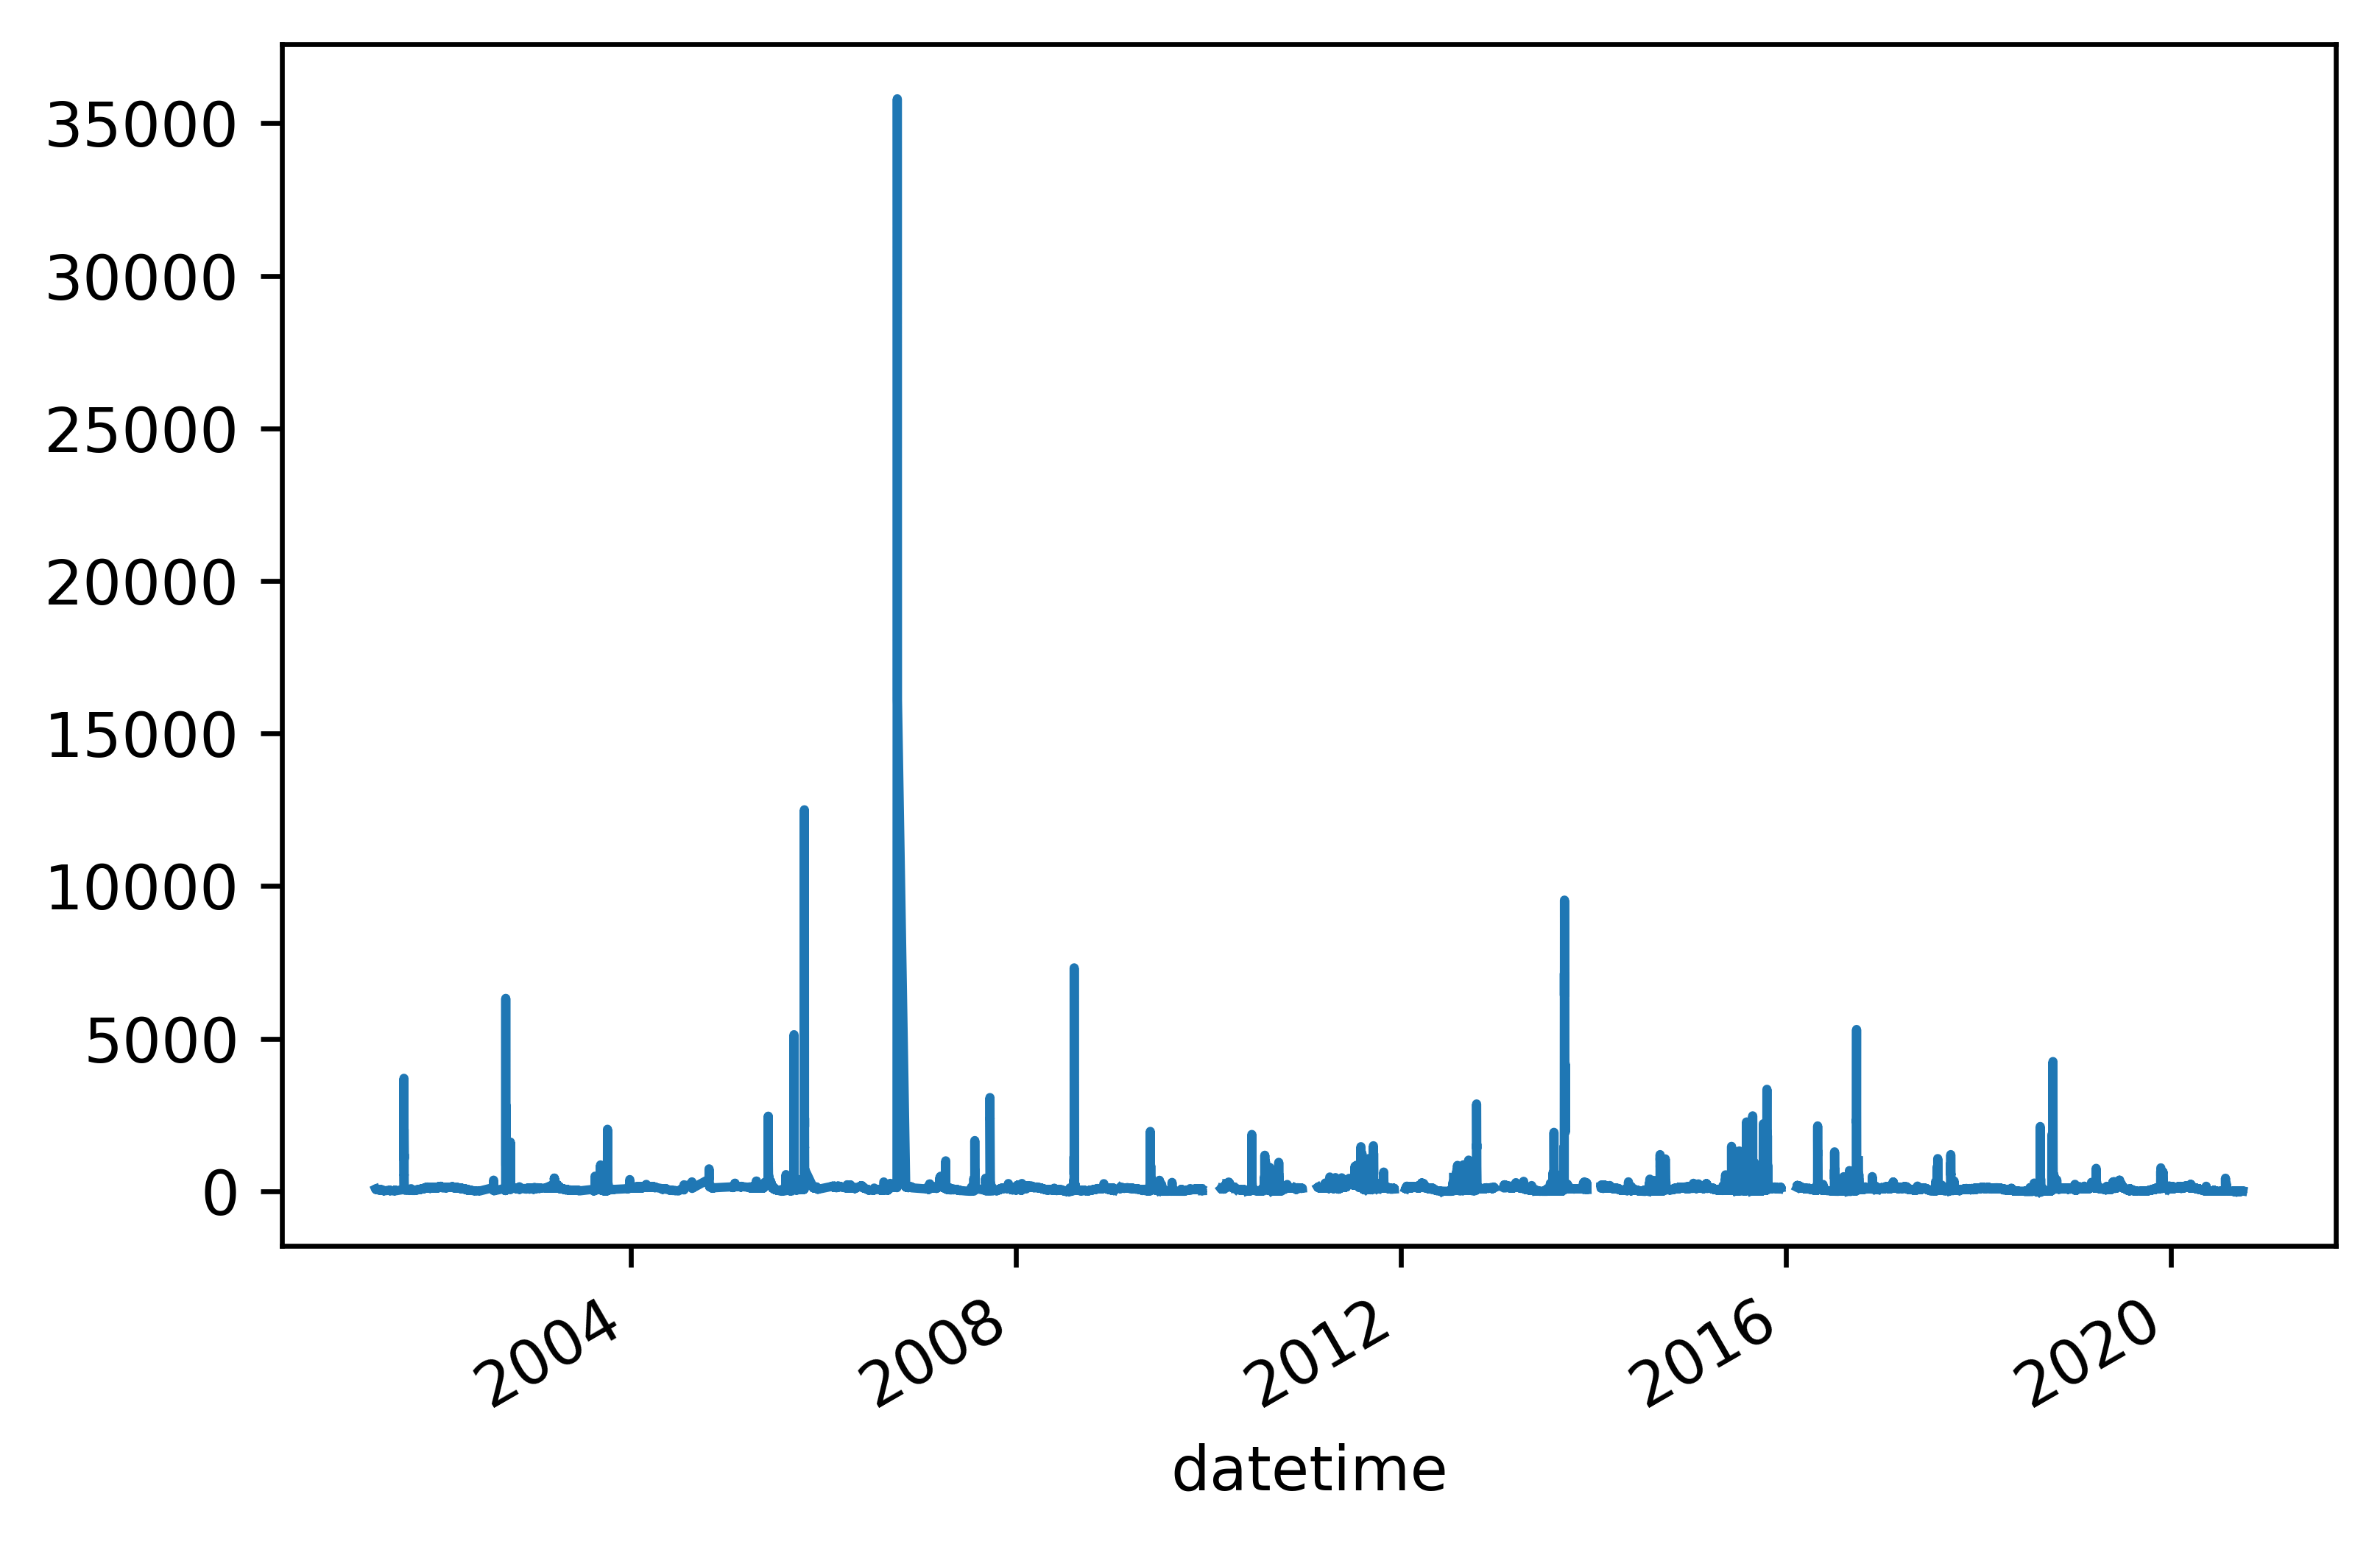

In [26]:
fig,ax = plt.subplots(dpi=600, figsize=(6,4))
dd.cfs.plot()

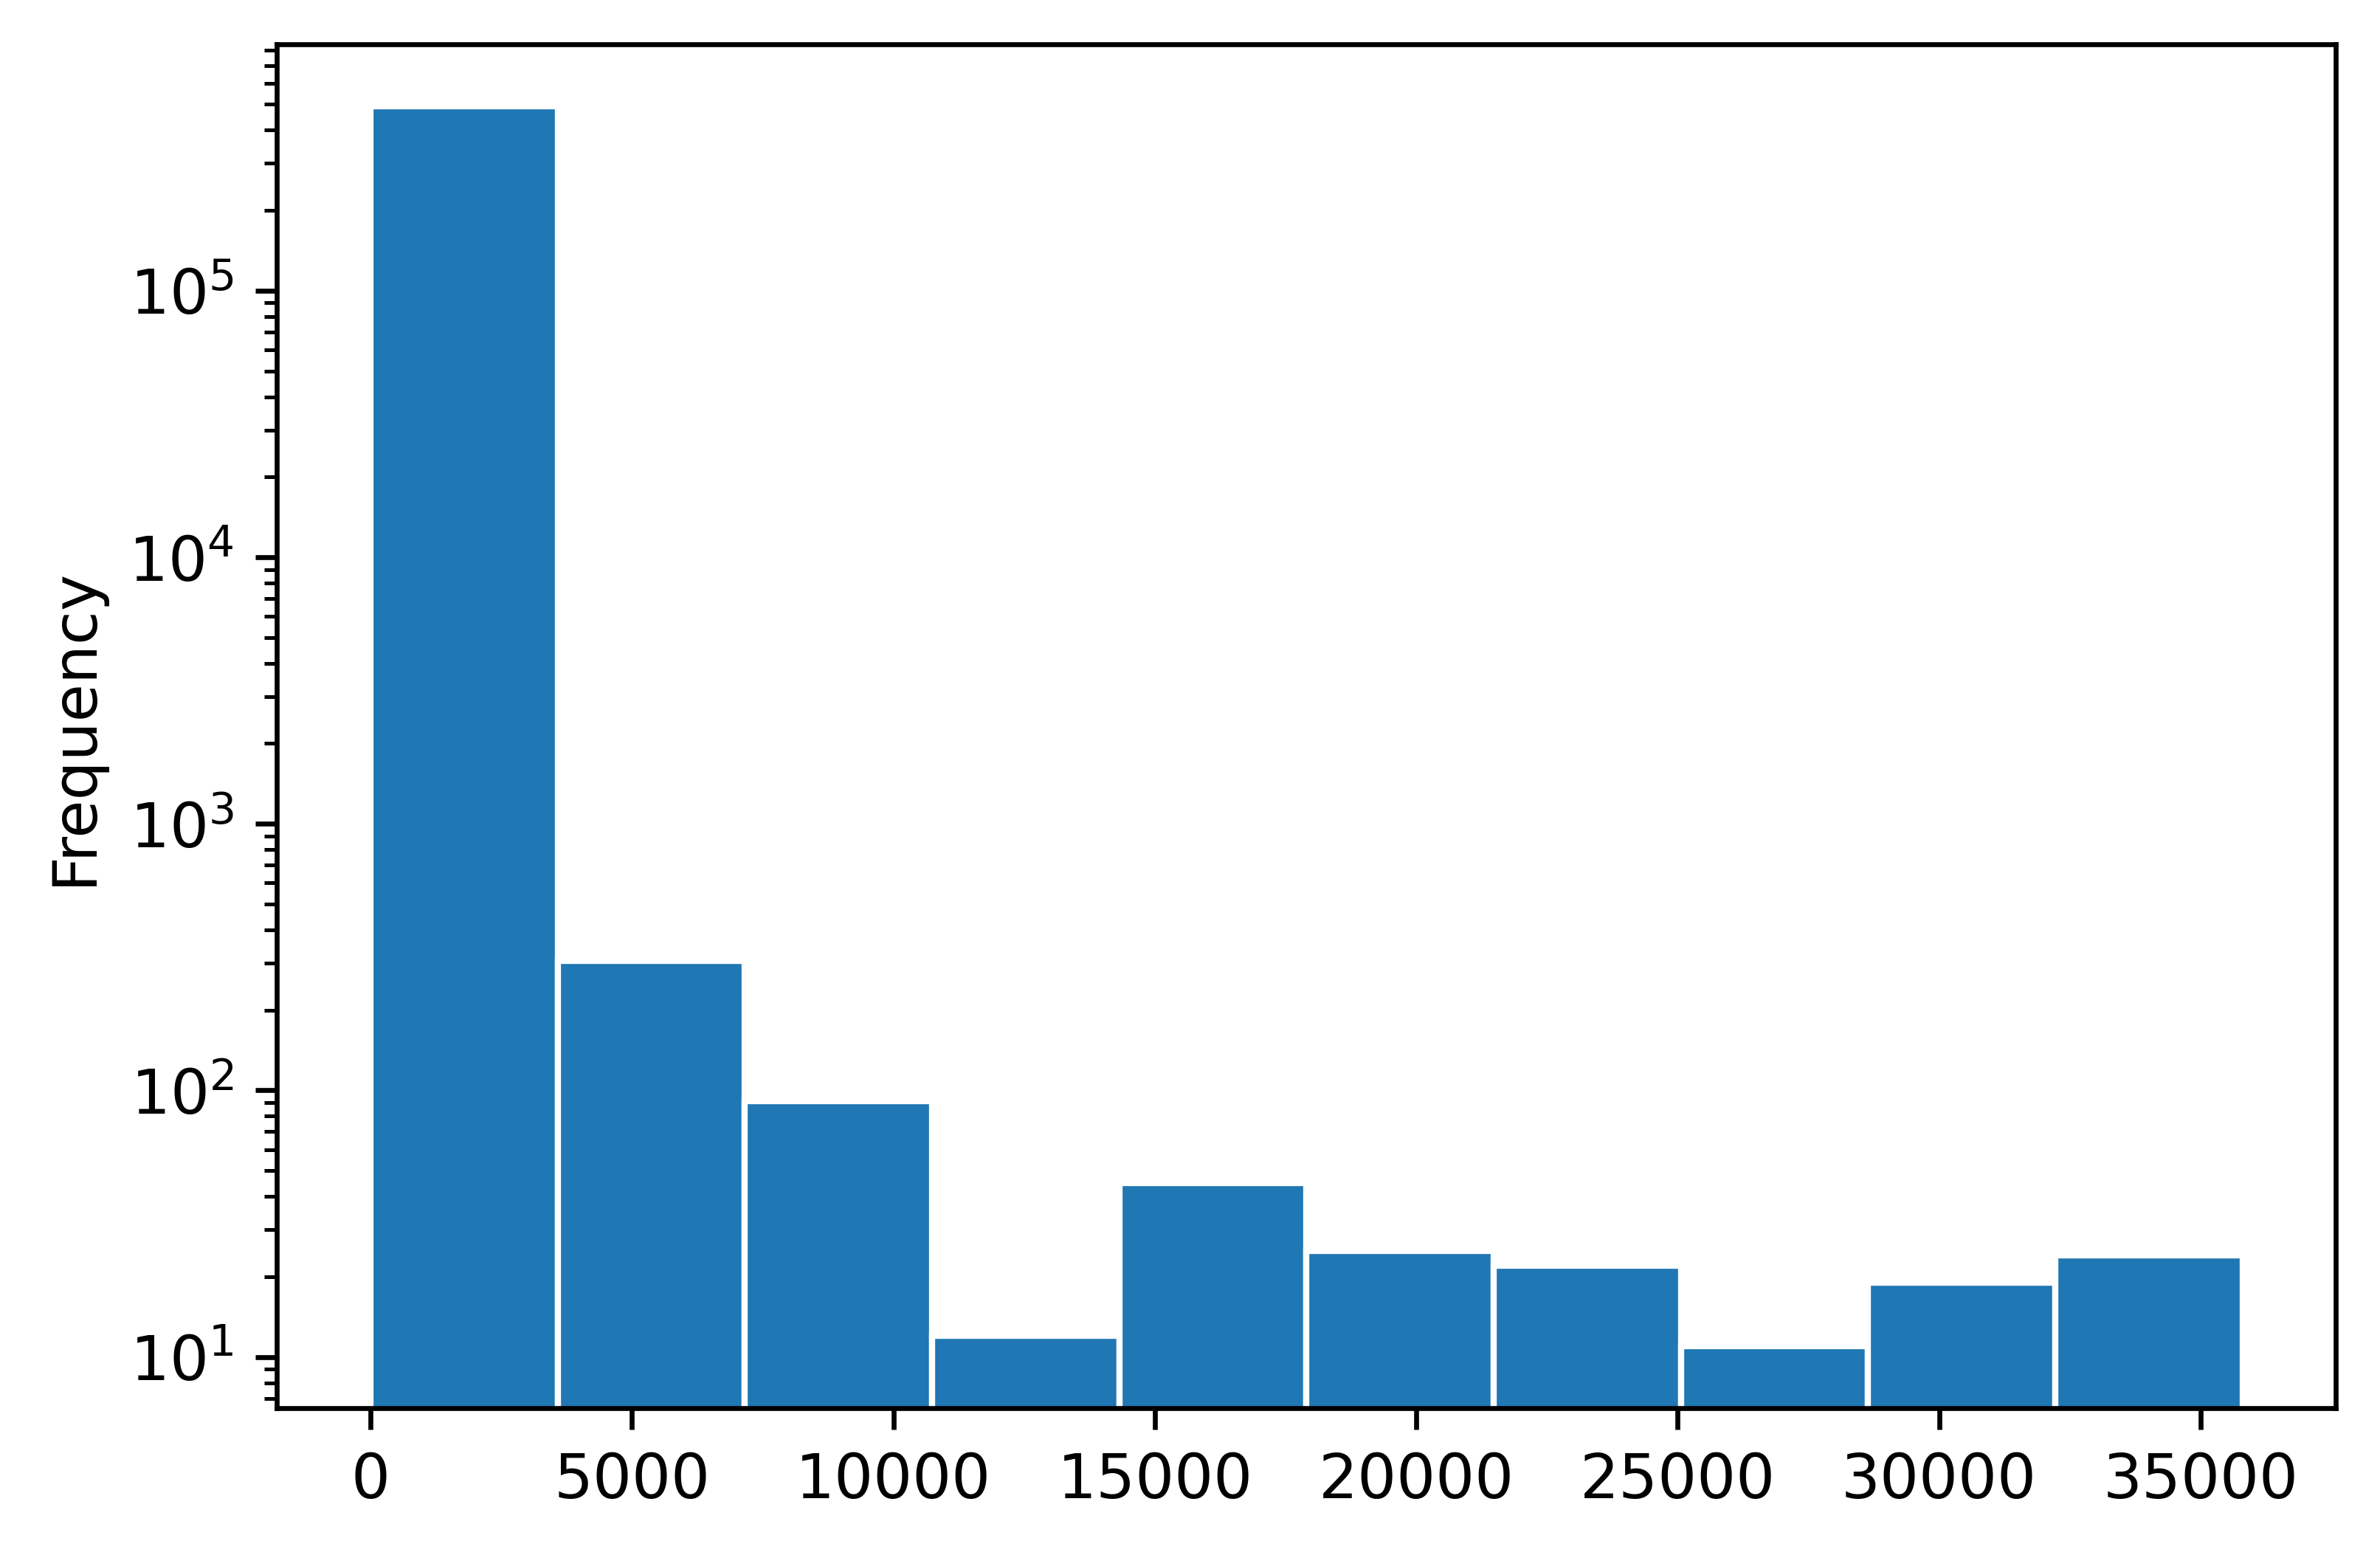

In [27]:
fig,ax = plt.subplots(dpi=600, figsize=(6,4))
dd.cfs.plot.hist(bins=10, edgecolor='white')
ax.set_yscale('log')

In [28]:
dd.cfs.describe()

count    493124.000000
mean        104.460537
std         477.341329
min           0.000000
25%          34.700000
50%          81.000000
75%         115.000000
max       35800.000000
Name: cfs, dtype: float64

### Slicing Time Series data
The above plots highlight significant outliers in teh dataset, which makes analysis and differentiation difficult.  To better break down the data, the use of the datetime index gives some helpful information to access the data.  It is possible to leverage string values to slice based on common date indicators, like year, month, day, day of week, quarter, etc.

Below the date range is filtered and clipped to focus on the underlying trend.

<Axes: xlabel='datetime'>

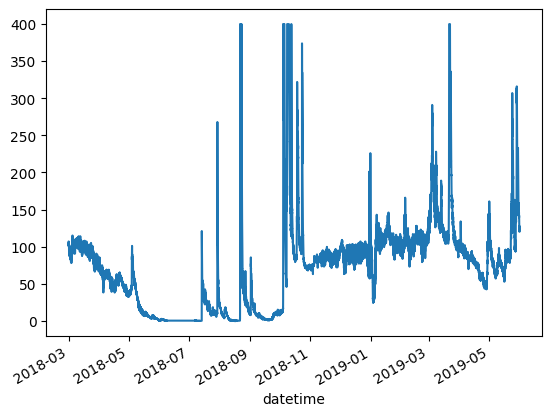

In [29]:
(dd
 .cfs
 .loc['2018/3':'2019/5'] # string date ranges to filter a datetime index
 .clip(upper = 400) # remove outliers
 .plot()
)

#### Rolling average applied
To better understand the trend, and have less response to intraday changes, applying a rolling average will provide a better understand of the data.  This requires us to set a window of time overwhich to apply the rolling average.

In [30]:
dd_2018 = (dd
           .cfs
           .loc['2018/3':'2019/5']
           .clip(upper=400)
          ) # this is still 15 min data points

Text(0.5, 1.0, 'Dirty Devil River Flow 2018 (cfs)')

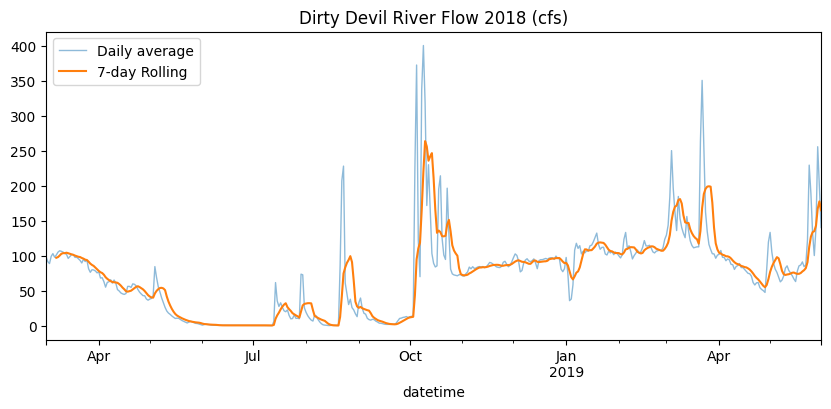

In [31]:
ax = (dd_2018
      .resample('D')
      .mean()
      .plot(figsize=(10,4), alpha=0.5, linewidth=1, label='Daily average')
     )

ax = (dd_2018
      .resample('D')
      .mean()
      .rolling(7)
      .mean()
      .plot(figsize=(10,4), ax=ax, label='7-day Rolling')
     )

ax.legend()
ax.set_title('Dirty Devil River Flow 2018 (cfs)')

### Missing data timeseries
When working with time series data, it has a unique attribute.  The data is ordered in time, which generally means the point measured (or missing) should have followed the trend of the data immediately preceeding it.  This allows the handling of missing data to be inferred more accurately. First, the amount of missing data must be identified to determine how to address the gaps.

In [32]:
(dd
 [['cfs']] # returns dataframe instead of series, allow query call to work correctly
 .loc['2018/3':'2019/5']
 .query('cfs.isna()')
)

cfs
datetime                      
2018-07-07 13:15:00-06:00  NaN
2018-07-07 13:30:00-06:00  NaN
2018-07-07 13:45:00-06:00  NaN
2018-07-07 14:00:00-06:00  NaN
2018-07-07 14:15:00-06:00  NaN
...                        ...
2018-08-18 08:15:00-06:00  NaN
2018-08-18 08:30:00-06:00  NaN
2018-08-18 08:45:00-06:00  NaN
2018-08-18 09:15:00-06:00  NaN
2018-08-18 10:30:00-06:00  NaN

[337 rows x 1 columns]

<Axes: xlabel='datetime'>

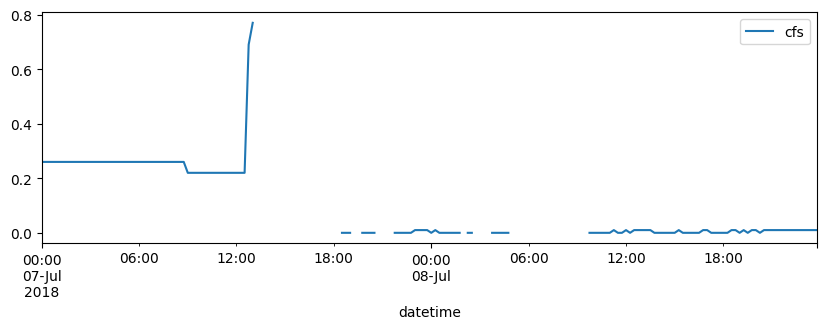

In [33]:
(dd
 [['cfs']] # returns dataframe instead of series, allow query call to work correctly
 .loc['2018/7/7':'2018/7/8']
 .plot(figsize=(10,3))
)

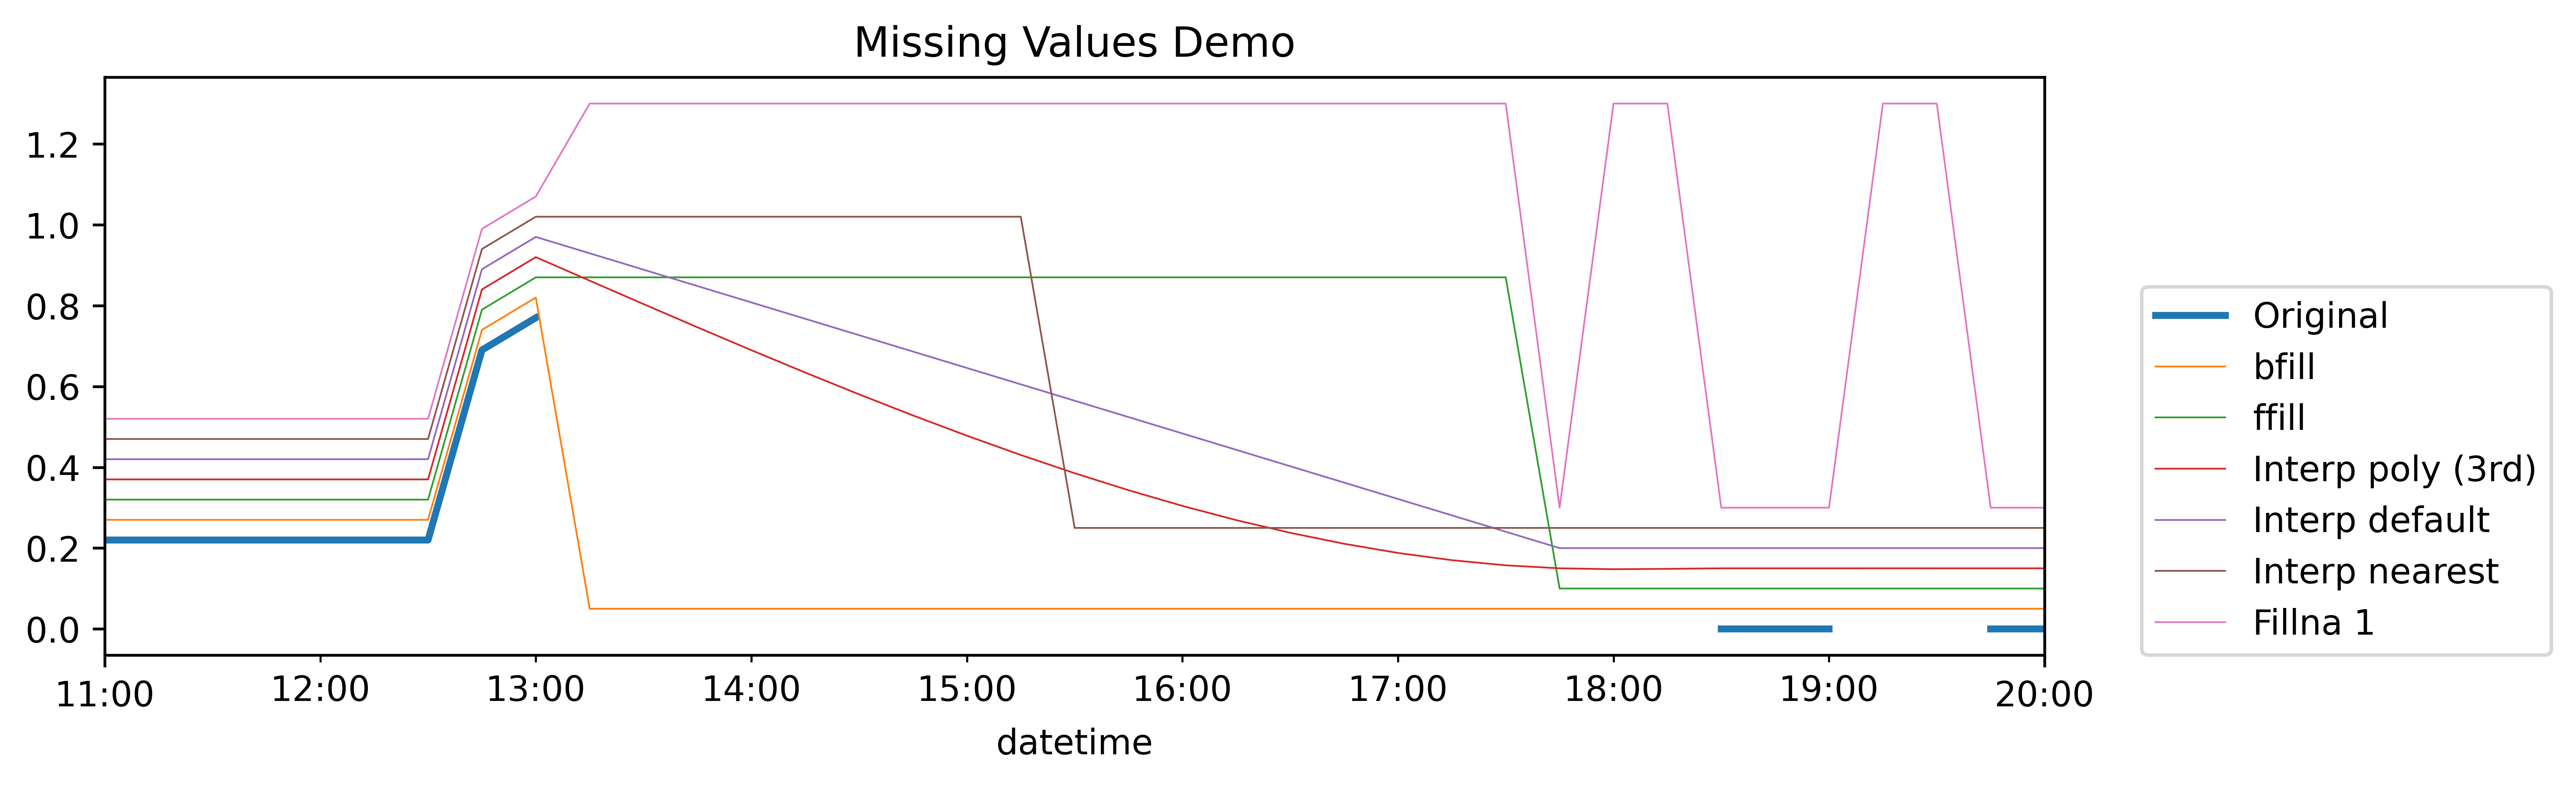

In [34]:
fig,ax = plt.subplots(dpi=600, figsize=(10,3))

dd_july = (dd['cfs'].loc['2018/7/7 11:00':'2018/7/7 20:00'])

(dd_july.plot(ax=ax, label='Original', linewidth=2))
(dd_july.bfill().add(0.05).plot(label='bfill',ax=ax, linewidth=0.5))
(dd_july.ffill().add(0.1).plot(label='ffill',ax=ax, linewidth=0.5))
(dd_july.interpolate(method='polynomial', order=3).add(0.15).plot(label='Interp poly (3rd)',ax=ax, linewidth=0.5))
(dd_july.interpolate().add(0.2).plot(label='Interp default',ax=ax, linewidth=0.5))
(dd_july.interpolate(method='nearest').add(0.25).plot(label='Interp nearest',ax=ax, linewidth=0.5))
(dd_july.fillna(1).add(0.3).plot(label='Fillna 1',ax=ax, linewidth=0.5))

ax.legend(loc=(1.05,0))
ax.set_title('Missing Values Demo');

### Exploring Seasonality
Timeseries data may or may not have a seasonal component.  Generally, weather patterns will deomstrate this attribute.  Things like monthly behavior across different periods of the year can lend themselves to understanding the data in different and enlightening ways.  With the datetime index, the access to this data restructure or data fold is available more readily.  

---
Achieving the details needed for seasonality could be accomadated with a resampling process, but it will place and end date for each month evaluated.  A groupby will provide an output with just 12 entries based on the month number, so you can run across different years and group everything seasonally. 

In [35]:
(dd
#  .resample('M') # all years will not be grouped
 .groupby(dd.index.month)
 .cfs
 .describe()
)

count        mean          std    min     25%    50%    75%  \
datetime                                                                  
1         26011.0  117.268802    29.000354  24.30  101.00  114.0  132.0   
2         41309.0  125.890293    24.280297  56.00  109.00  125.0  141.0   
3         51807.0  127.037609    48.885942  60.30  100.00  116.0  136.0   
4         50669.0   82.786214    74.133528  20.50   52.50   70.0   97.8   
5         49507.0   63.007851    68.791835   0.31   27.20   43.9   78.5   
6         41379.0   74.327241   139.857378   0.02    8.93   32.0   82.5   
7         37089.0   62.775011   115.285805   0.00    4.25   17.4   68.2   
8         37584.0   74.676246   247.800553   0.00    6.30   25.6   59.1   
9         42272.0  128.309332   546.921269   0.00    7.55   20.0   55.9   
10        44647.0  196.285529  1455.942059   6.44   40.90   57.4   80.9   
11        42165.0   97.194344    39.743333  53.40   81.50   89.3  105.0   
12        28685.0  100.042608    26.700535  17.00   86.50   97.8  113.0   

              max  
datetime           
1           265.0  
2           303.0  
3           750.0  
4          2140.0  
5          1960.0  
6          2460.0  
7          1660.0  
8          7320.0  
9          9540.0  
10        35800.0  
11          766.0  
12          407.0

In [36]:
plt.style.use('ggplot')

<Axes: xlabel='datetime'>

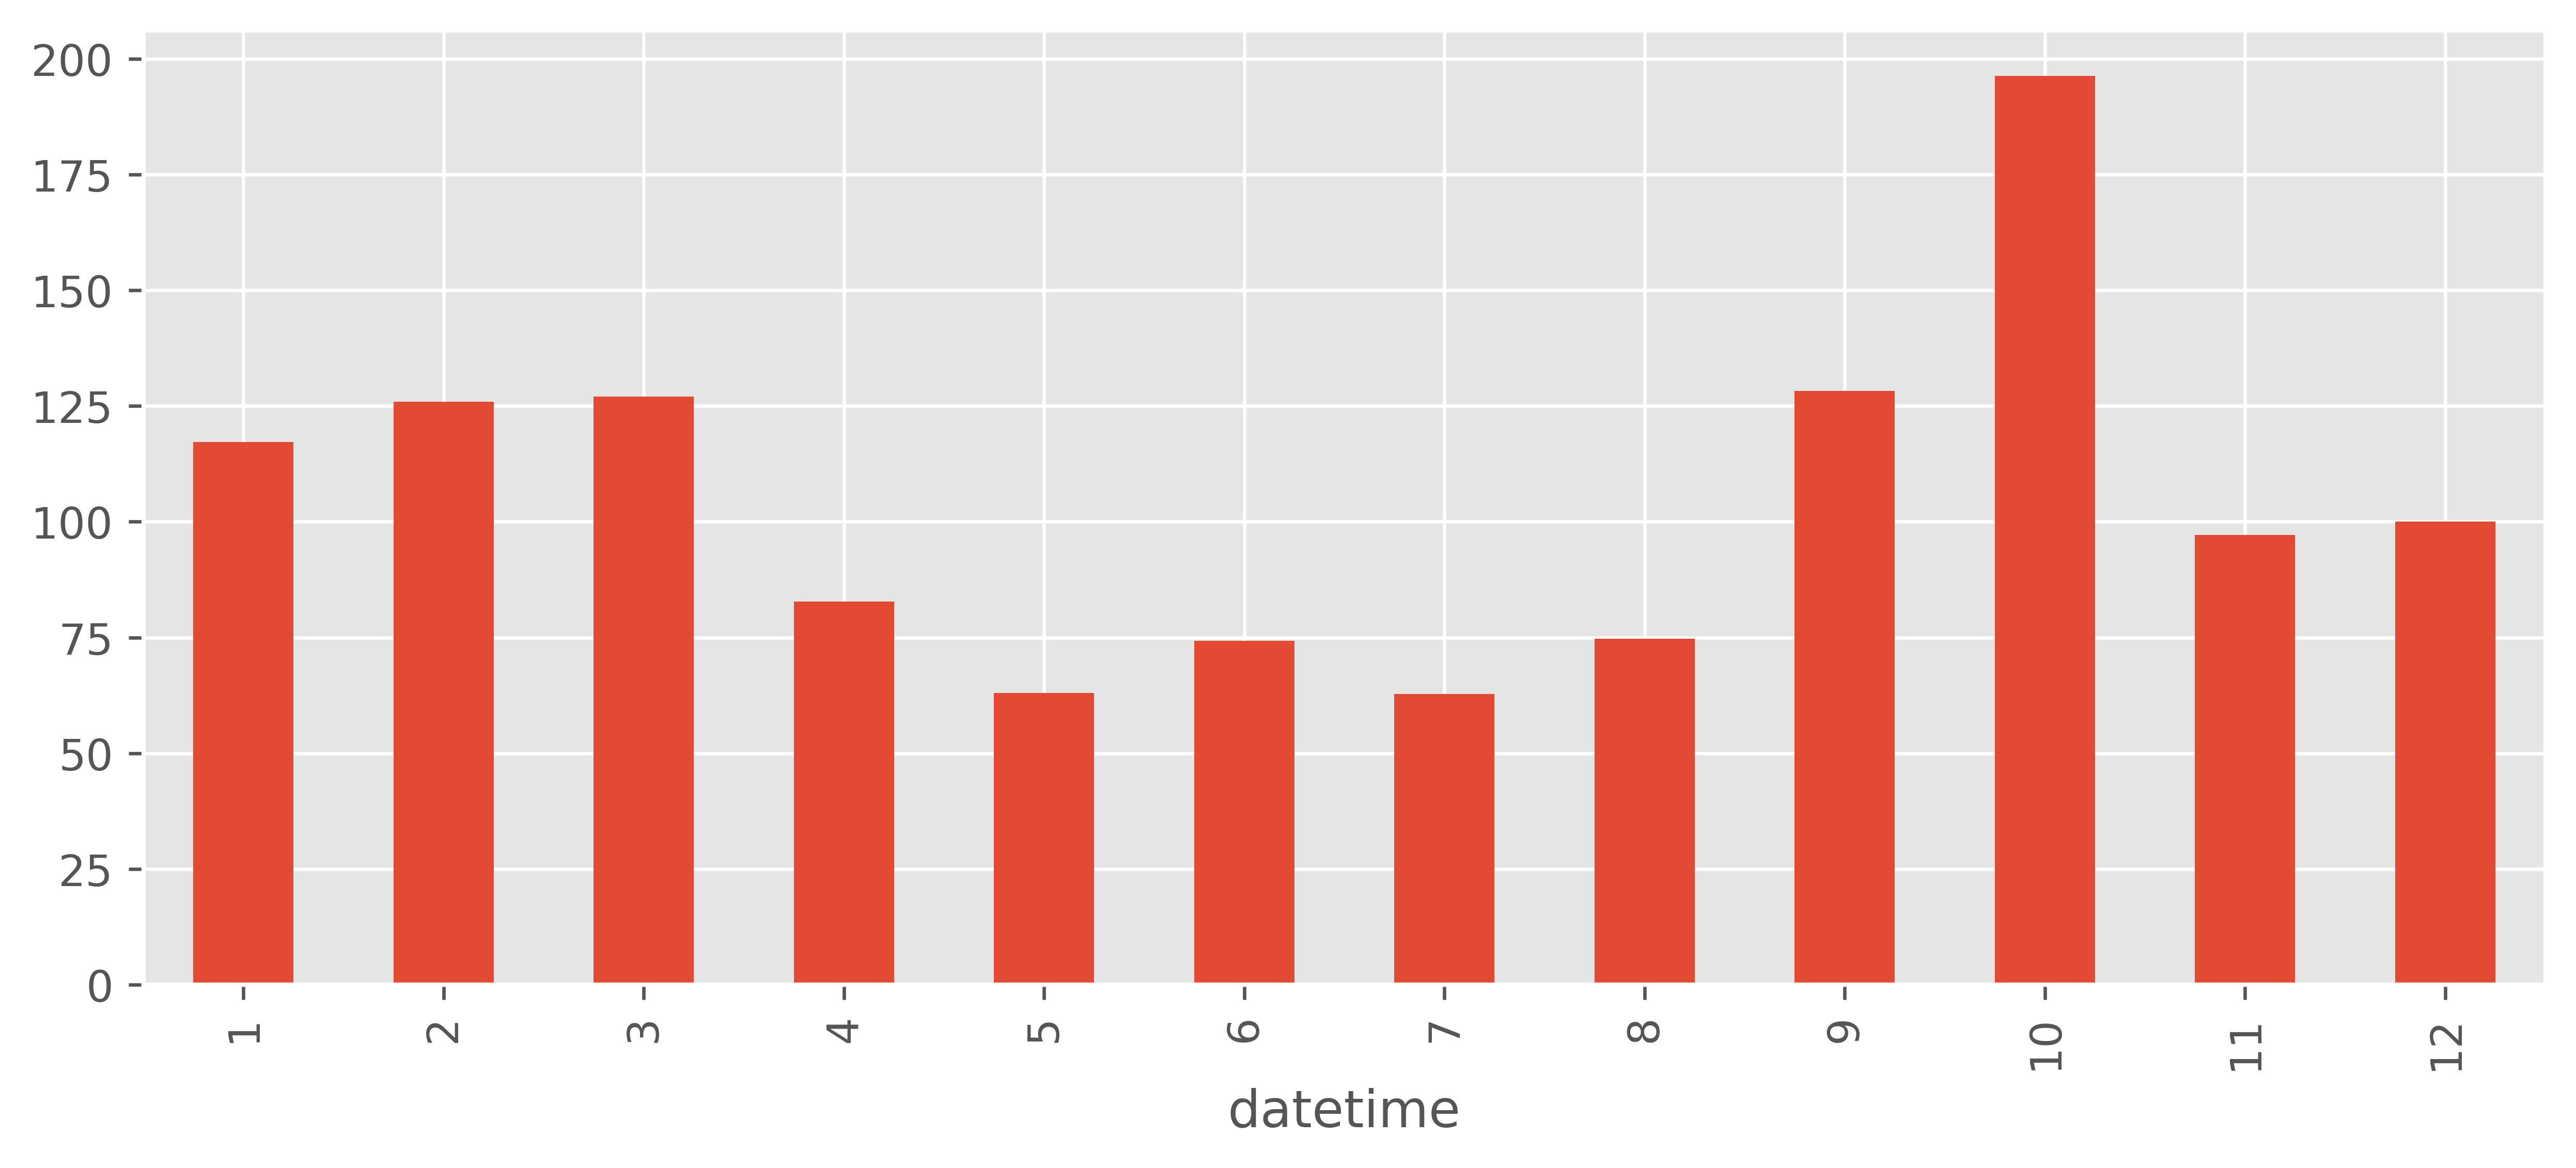

In [37]:
fig,ax = plt.subplots(dpi=600, figsize=(10,4))
(dd
 .groupby(dd.index.month)
 .cfs
 .mean()
 .plot.bar(ax=ax)
)

In [38]:
import seaborn as sns

<Axes: xlabel='datetime'>

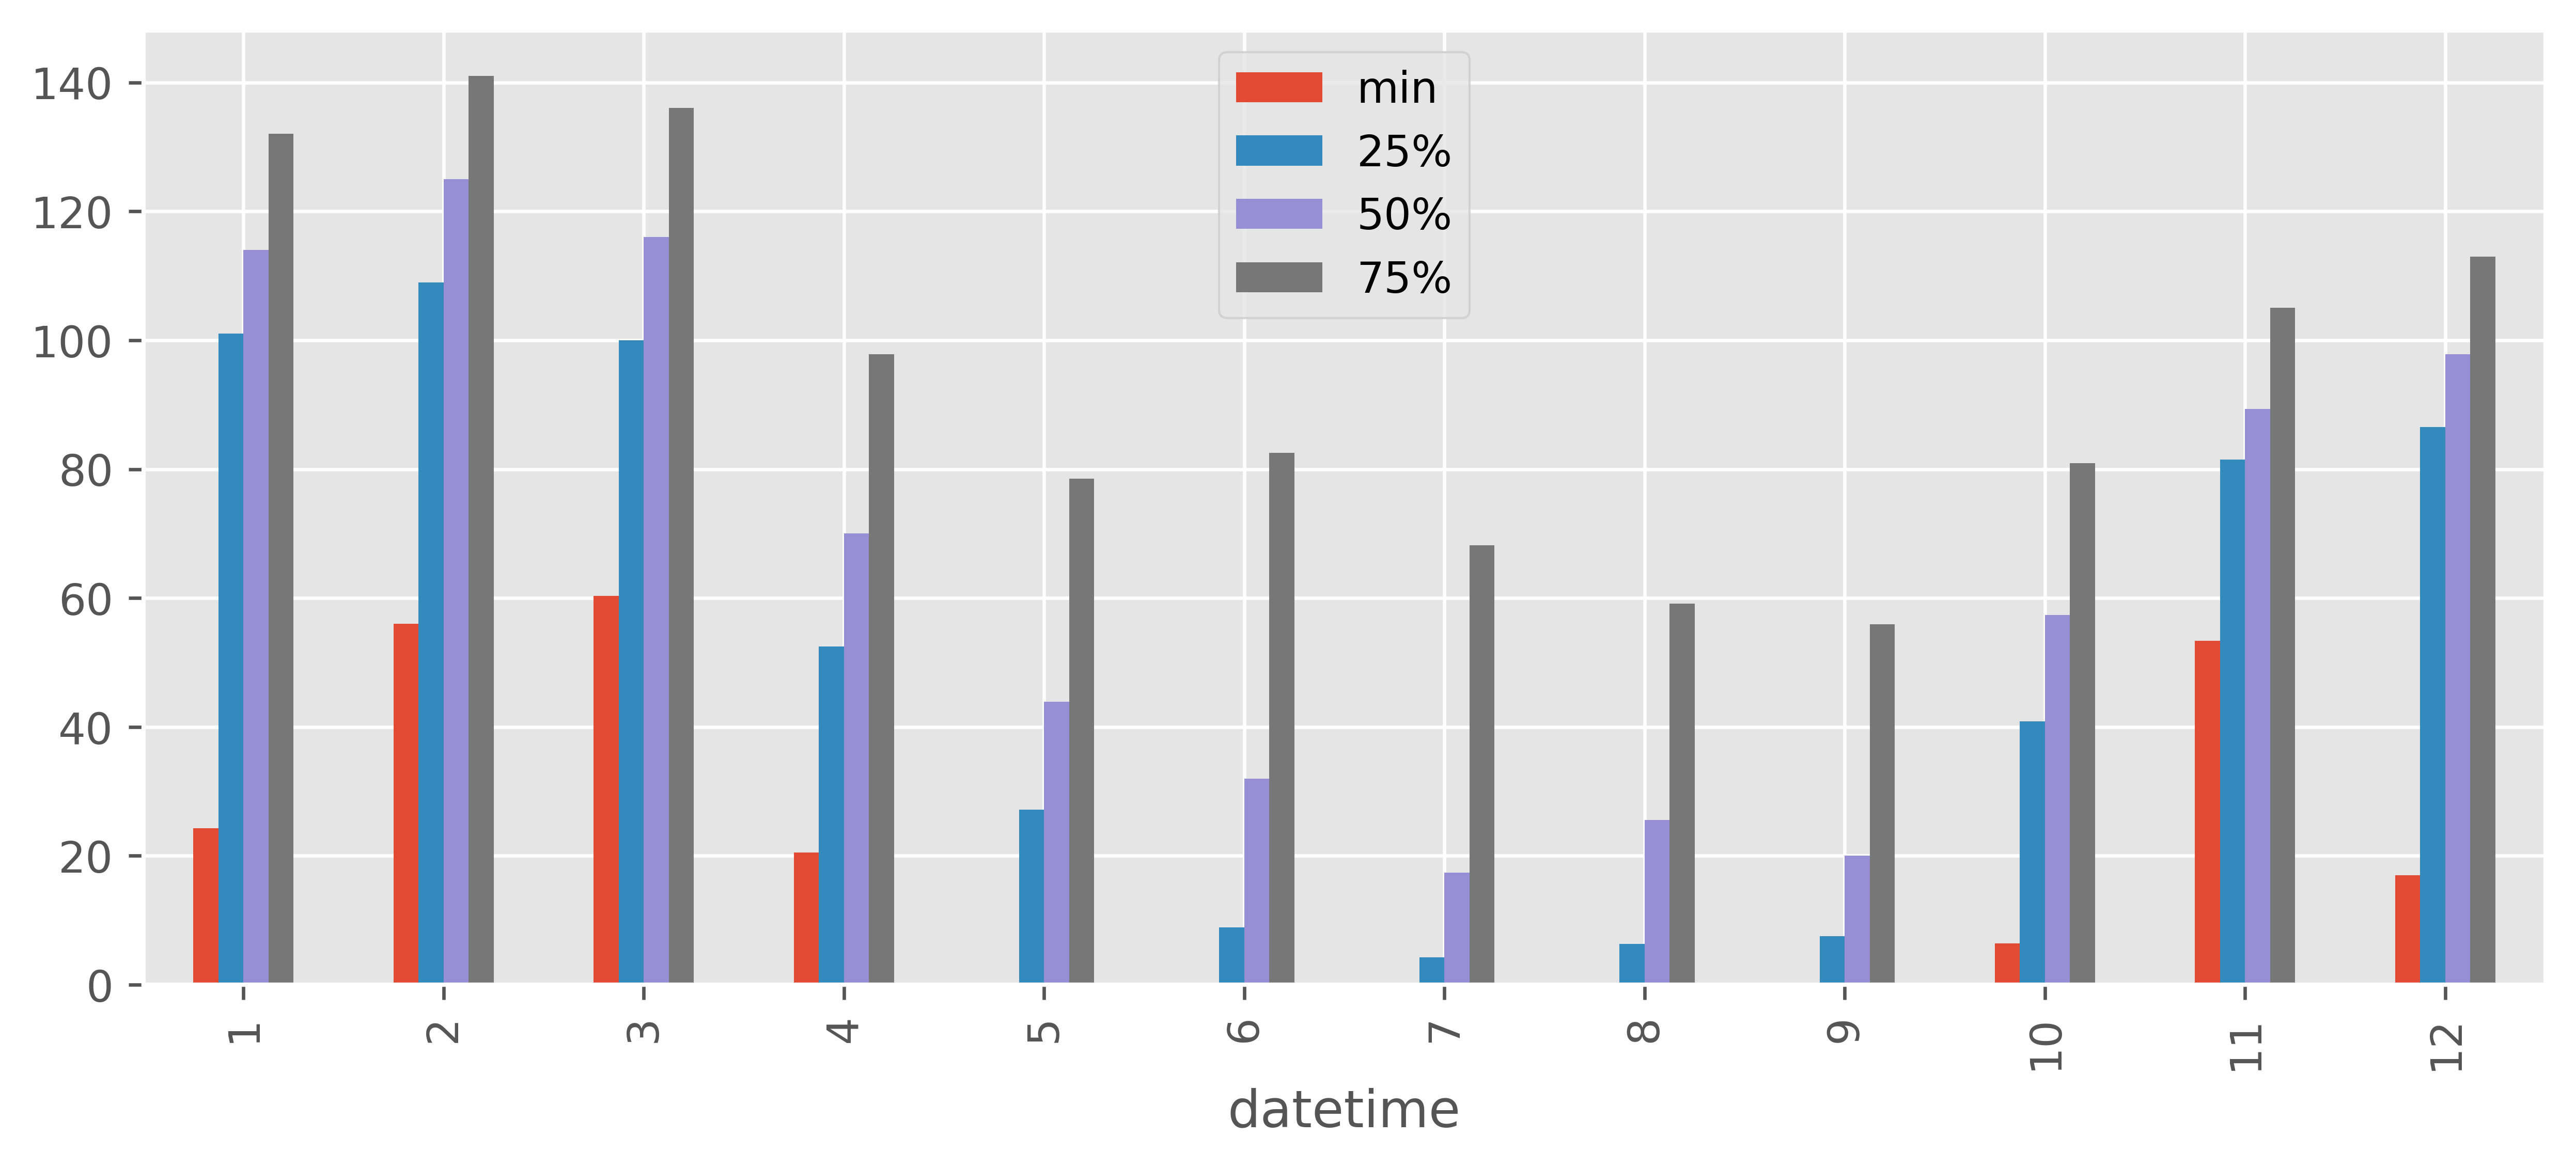

In [39]:
fig,ax = plt.subplots(dpi=600, figsize=(10,4))
(dd
 .groupby(dd.index.month)
 .cfs
 .describe()
 .loc[:,'min':'75%'] # dropping max due to outliers blowing out y scale
 .plot.bar(ax=ax)
)

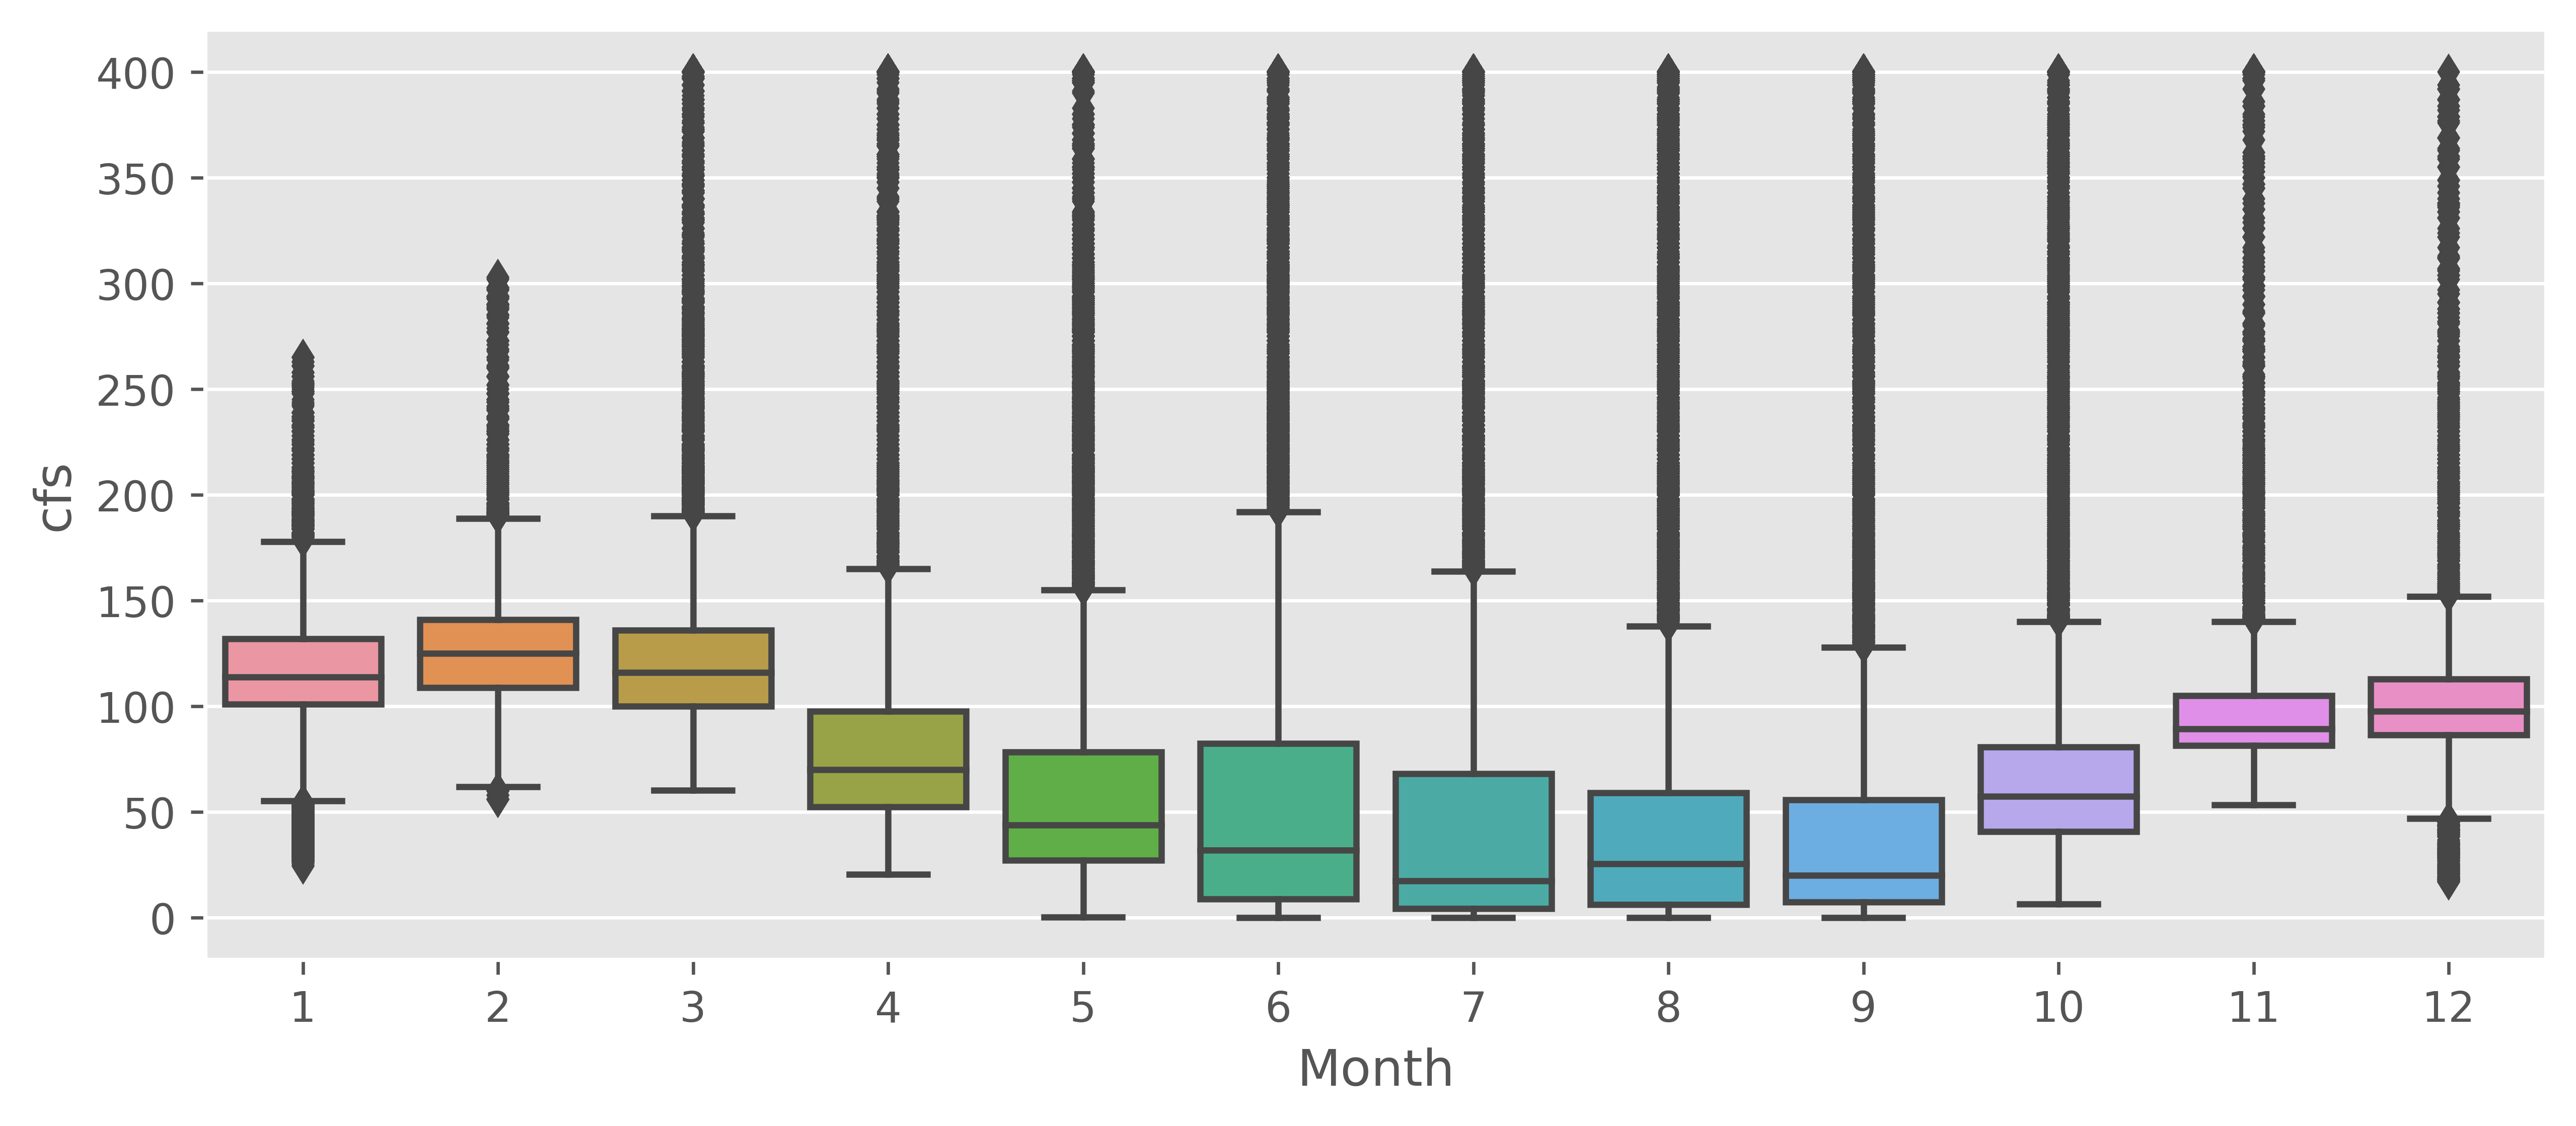

In [40]:
fig,ax = plt.subplots(dpi=600, figsize=(10,4))
sns.boxplot(data=dd.assign(cfs=dd.cfs.clip(upper=400)),
           x=dd.index.month.rename('Month'),y='cfs', ax=ax);

>**Note**: Plots like these can definitely provide an understanding of larger historic trends.  If there is an interest to progress to a deeper level of analysis, a library such as Kats will be helpful in progressing the analysis further.

### Resampling Data
This was explored previously, but here the value can be demonstrated more effectively as the data from the dirty devil river was captured in 15min incraments.  Using the resampling tool, there is a lot of information which can be investigated at different time intervals.

In [41]:
dd.cfs.head(4)

datetime
2001-05-07 01:00:00-06:00    71.0
2001-05-07 01:15:00-06:00    71.0
2001-05-07 01:30:00-06:00    71.0
2001-05-07 01:45:00-06:00    70.0
Name: cfs, dtype: float64

In [42]:
# moving to single day and the median value to remove impact of outliers (see income levels)
(dd
 .resample('D')
 [['cfs']]
 .median()
)

cfs
datetime                        
2001-05-07 00:00:00-06:00  71.50
2001-05-08 00:00:00-06:00  69.00
2001-05-09 00:00:00-06:00  63.50
2001-05-10 00:00:00-06:00  55.00
2001-05-11 00:00:00-06:00  55.00
...                          ...
2020-09-24 00:00:00-06:00   9.53
2020-09-25 00:00:00-06:00  10.20
2020-09-26 00:00:00-06:00  10.90
2020-09-27 00:00:00-06:00  10.20
2020-09-28 00:00:00-06:00   9.53

[7085 rows x 1 columns]

In [43]:
# moving to bi-daily with a simple numerical code addition
(dd
 .resample('2D') # encoding the offset
 [['cfs']]
 .median()
)

cfs
datetime                        
2001-05-07 00:00:00-06:00  69.00
2001-05-09 00:00:00-06:00  56.00
2001-05-11 00:00:00-06:00  54.00
2001-05-13 00:00:00-06:00  47.00
2001-05-15 00:00:00-06:00  54.00
...                          ...
2020-09-20 00:00:00-06:00   6.83
2020-09-22 00:00:00-06:00   7.68
2020-09-24 00:00:00-06:00   9.86
2020-09-26 00:00:00-06:00  10.50
2020-09-28 00:00:00-06:00   9.53

[3543 rows x 1 columns]

### Infinite resampling options
Here the power of resampling is shown with a detailed offset simply passed as a string.  Remember, this only works when the data is in a true datetime format and has been pushed into the index.  There are many more ways to leverage this concept, but here some of the capability is shown.  Need shift details, this process can readily allow for a unique sampling basis for the data.

In [44]:
(dd
 .resample('3D2H10min') # encoding any time based offset
 [['cfs']]
 .median()
)

cfs
datetime                        
2001-05-07 00:00:00-06:00  67.00
2001-05-10 02:10:00-06:00  55.00
2001-05-13 04:20:00-06:00  49.00
2001-05-16 06:30:00-06:00  50.00
2001-05-19 08:40:00-06:00  46.00
...                          ...
2020-09-14 13:20:00-06:00   5.79
2020-09-17 15:30:00-06:00   6.04
2020-09-20 17:40:00-06:00   7.11
2020-09-23 19:50:00-06:00  10.03
2020-09-26 22:00:00-06:00   9.86

[2293 rows x 1 columns]

### Anchored offset aliases
The ability to resample with time series data gets even further afield.  The option to reset the resample window is also available to allow the data to be aligned with business or industry rules.  If, for example, there is an interest in setting the weekly, quarterly or yearly window endpoint, this option is available withing the resampling of a datetime index.

In [45]:
(dd
 .resample('Q') # default is end of Mar, Jun, Sep, Dec
 .cfs
 .median()
)

datetime
2001-06-30 00:00:00-06:00     44.00
2001-09-30 00:00:00-06:00     27.00
2001-12-31 00:00:00-07:00     85.00
2002-03-31 00:00:00-07:00    122.00
2002-06-30 00:00:00-06:00     46.00
                              ...  
2019-09-30 00:00:00-06:00     13.30
2019-12-31 00:00:00-07:00     92.10
2020-03-31 00:00:00-06:00    126.00
2020-06-30 00:00:00-06:00     23.20
2020-09-30 00:00:00-06:00      5.79
Freq: Q-DEC, Name: cfs, Length: 78, dtype: float64

In [46]:
(dd
 .resample('Q-JAN') # Modifying the window for quarters to end of JAN, ARP, JUL, OCT
 .cfs
 .median()
)

datetime
2001-07-31 00:00:00-06:00     42.0
2001-10-31 00:00:00-07:00     39.0
2002-01-31 00:00:00-07:00    116.0
2002-04-30 00:00:00-06:00     96.0
2002-07-31 00:00:00-06:00     13.0
                             ...  
2019-10-31 00:00:00-06:00     12.8
2020-01-31 00:00:00-07:00    116.0
2020-04-30 00:00:00-06:00    116.0
2020-07-31 00:00:00-06:00     13.9
2020-10-31 00:00:00-06:00      0.5
Freq: Q-JAN, Name: cfs, Length: 78, dtype: float64

In [47]:
(dd
 .resample('W') # Weekly offset default is SUN
 .cfs
 .median()
)

datetime
2001-05-13 00:00:00-06:00    56.00
2001-05-20 00:00:00-06:00    49.00
2001-05-27 00:00:00-06:00    43.00
2001-06-03 00:00:00-06:00    34.00
2001-06-10 00:00:00-06:00    21.00
                             ...  
2020-09-06 00:00:00-06:00     0.02
2020-09-13 00:00:00-06:00     0.01
2020-09-20 00:00:00-06:00     6.04
2020-09-27 00:00:00-06:00     9.20
2020-10-04 00:00:00-06:00     9.53
Freq: W-SUN, Name: cfs, Length: 1013, dtype: float64

In [48]:
(dd
 .resample('W-MON') # Weekly offset changed to MON (last date moved to prior week)
 .cfs
 .median()
)

datetime
2001-05-07 00:00:00-06:00    71.50
2001-05-14 00:00:00-06:00    55.00
2001-05-21 00:00:00-06:00    49.00
2001-05-28 00:00:00-06:00    43.00
2001-06-04 00:00:00-06:00    30.00
                             ...  
2020-08-31 00:00:00-06:00     0.05
2020-09-07 00:00:00-06:00     0.02
2020-09-14 00:00:00-06:00     5.27
2020-09-21 00:00:00-06:00     6.04
2020-09-28 00:00:00-06:00     9.53
Freq: W-MON, Name: cfs, Length: 1013, dtype: float64

### Resampling at finer-grain frequency - (creating data)
What happens when you want to got the other direction, setting the sample finer than the recorded data, esentially creating phantom points in between the existing recorded points.  Generally some sort of function will need to be defined with a higher frequency resample than the base data.  Typical options are interpolation, ffill and bfill.

In [49]:
(dd
 .resample('2min')
 .cfs
 .median() # Check out all the empties in teh data
)

datetime
2001-05-07 01:00:00-06:00    71.0
2001-05-07 01:02:00-06:00     NaN
2001-05-07 01:04:00-06:00     NaN
2001-05-07 01:06:00-06:00     NaN
2001-05-07 01:08:00-06:00     NaN
                             ... 
2020-09-28 09:22:00-06:00     NaN
2020-09-28 09:24:00-06:00     NaN
2020-09-28 09:26:00-06:00     NaN
2020-09-28 09:28:00-06:00     NaN
2020-09-28 09:30:00-06:00     9.2
Freq: 2T, Name: cfs, Length: 5100736, dtype: float64

In [50]:
(dd
 .resample('2min')
 .cfs
 .median() 
 .interpolate() # fills in data points
)

datetime
2001-05-07 01:00:00-06:00    71.0
2001-05-07 01:02:00-06:00    71.0
2001-05-07 01:04:00-06:00    71.0
2001-05-07 01:06:00-06:00    71.0
2001-05-07 01:08:00-06:00    71.0
                             ... 
2020-09-28 09:22:00-06:00     9.2
2020-09-28 09:24:00-06:00     9.2
2020-09-28 09:26:00-06:00     9.2
2020-09-28 09:28:00-06:00     9.2
2020-09-28 09:30:00-06:00     9.2
Freq: 2T, Name: cfs, Length: 5100736, dtype: float64

In [51]:
(dd
 .resample('2min')
 [['cfs']]
 .median() 
 .assign(bfill = lambda df: df.cfs.bfill(),
         ffill = lambda df: df.cfs.ffill(),
         inter_poly = lambda df: df.cfs.interpolate(method='polynomial', order=2),
         inter_near = lambda df: df.cfs.interpolate(method='nearest'))
).head(20) # showing how to create and then options to fill the data created.

cfs  bfill  ffill  inter_poly  inter_near
datetime                                                             
2001-05-07 01:00:00-06:00  71.0   71.0   71.0   71.000000        71.0
2001-05-07 01:02:00-06:00   NaN   71.0   71.0   70.985161        71.0
2001-05-07 01:04:00-06:00   NaN   71.0   71.0   70.975268        71.0
2001-05-07 01:06:00-06:00   NaN   71.0   71.0   70.970322        71.0
2001-05-07 01:08:00-06:00   NaN   71.0   71.0   70.970322        71.0
2001-05-07 01:10:00-06:00   NaN   71.0   71.0   70.975268        71.0
2001-05-07 01:12:00-06:00   NaN   71.0   71.0   70.985161        71.0
2001-05-07 01:14:00-06:00  71.0   71.0   71.0   71.000000        71.0
2001-05-07 01:16:00-06:00   NaN   71.0   71.0   71.019785        71.0
2001-05-07 01:18:00-06:00   NaN   71.0   71.0   71.044517        71.0
2001-05-07 01:20:00-06:00   NaN   71.0   71.0   71.074195        71.0
2001-05-07 01:22:00-06:00   NaN   71.0   71.0   71.108819        71.0
2001-05-07 01:24:00-06:00   NaN   71.0   71.0   71.129841        71.0
2001-05-07 01:26:00-06:00   NaN   71.0   71.0   71.118712        71.0
2001-05-07 01:28:00-06:00   NaN   71.0   71.0   71.075431        71.0
2001-05-07 01:30:00-06:00  71.0   71.0   71.0   71.000000        71.0
2001-05-07 01:32:00-06:00   NaN   70.0   71.0   70.892417        71.0
2001-05-07 01:34:00-06:00   NaN   70.0   71.0   70.752684        71.0
2001-05-07 01:36:00-06:00   NaN   70.0   71.0   70.580799        71.0
2001-05-07 01:38:00-06:00   NaN   70.0   71.0   70.385503        70.0

### Grouping a Date Column with pd.Grouper
As an alternate approach to the powerful resampling method, there is the option to use the pd.Grouper class.  The focus here would be to leverage a datetime column in place of having the data in the index.  It is sometimes perferable to keep the index clean versus being required to push the datetime data into this space.

In [52]:
(dd # resample approach
 .resample('Q-JAN')
 .cfs
 .median()
)

datetime
2001-07-31 00:00:00-06:00     42.0
2001-10-31 00:00:00-07:00     39.0
2002-01-31 00:00:00-07:00    116.0
2002-04-30 00:00:00-06:00     96.0
2002-07-31 00:00:00-06:00     13.0
                             ...  
2019-10-31 00:00:00-06:00     12.8
2020-01-31 00:00:00-07:00    116.0
2020-04-30 00:00:00-06:00    116.0
2020-07-31 00:00:00-06:00     13.9
2020-10-31 00:00:00-06:00      0.5
Freq: Q-JAN, Name: cfs, Length: 78, dtype: float64

In [53]:
(dd # pd.Grouper method.  Reset index could also be used after resample call as well, but would reset index
 .reset_index()
 .groupby(pd.Grouper(key='datetime', freq='Q-JAN'))
 .cfs
 .median()
)

datetime
2001-07-31 00:00:00-06:00     42.0
2001-10-31 00:00:00-07:00     39.0
2002-01-31 00:00:00-07:00    116.0
2002-04-30 00:00:00-06:00     96.0
2002-07-31 00:00:00-06:00     13.0
                             ...  
2019-10-31 00:00:00-06:00     12.8
2020-01-31 00:00:00-07:00    116.0
2020-04-30 00:00:00-06:00    116.0
2020-07-31 00:00:00-06:00     13.9
2020-10-31 00:00:00-06:00      0.5
Freq: Q-JAN, Name: cfs, Length: 78, dtype: float64

### P-Set
With a dataset of your choice:
1. Convert a date column from a string to a datetime
2. Group the data by month names and look at the mean values.
3. Group the data by each month of every year and look at the mean values.
4. Insert the date colum in the index and slice out a portion of the rows by date.

In [54]:
(fifa
 .assign(month = lambda df:df.date.dt.month)
#  .select_dtypes('number')
 .groupby('month')
 .mean(numeric_only=True)
)

home_team_fifa_rank  away_team_fifa_rank  home_team_total_fifa_points  \
month                                                                          
1                74.742555            78.929848                   274.029120   
2                74.169107            72.190337                   107.665447   
3                82.844005            85.321692                   387.066744   
4                85.592715            90.344371                    18.634658   
5                76.364992            85.539246                   180.644427   
6                67.224555            72.283844                   419.769022   
7                78.610980            82.950588                   254.472941   
8                78.398224            81.635085                   126.495189   
9                79.321529            78.402174                   397.761220   
10               77.304721            78.677781                   406.982833   
11               80.429204            83.627950                   440.867625   
12              100.991176           104.708824                   169.697059   

       away_team_total_fifa_points  home_team_score  away_team_score  \
month                                                                  
1                       272.388484         1.421575         0.956982   
2                       105.150805         1.469253         1.126647   
3                       378.317423         1.600310         1.040357   
4                        17.320088         1.837748         0.993377   
5                       154.729984         1.621664         0.977237   
6                       397.715662         1.643775         1.070652   
7                       240.475294         1.613333         1.078431   
8                       122.489267         1.625463         1.057735   
9                       399.908836         1.601683         1.133240   
10                      402.962364         1.639815         1.130736   
11                      438.398599         1.630531         1.042035   
12                      167.564706         1.588235         1.100000   

       neutral_location  home_team_goalkeeper_score  \
month                                                 
1              0.518200                   71.209354   
2              0.334553                   73.635514   
3              0.162980                   74.947577   
4              0.172185                   74.431034   
5              0.288854                   75.250000   
6              0.335721                   76.365882   
7              0.450196                   76.511785   
8              0.153220                   73.822281   
9              0.110449                   74.903199   
10             0.113899                   74.899172   
11             0.182153                   75.240637   
12             0.486275                   69.609524   

       away_team_goalkeeper_score  home_team_mean_defense_score  \
month                                                             
1                       70.828235                     72.429157   
2                       73.677515                     74.210847   
3                       74.365112                     75.089752   
4                       71.980769                     73.884906   
5                       72.600575                     75.069003   
6                       74.948391                     75.930126   
7                       74.371648                     75.523973   
8                       74.167139                     73.940882   
9                       74.430195                     74.618326   
10                      74.792482                     74.820789   
11                      74.537655                     75.155600   
12                      70.732283                     70.557812   

       home_team_mean_offense_score  home_team_mean_midfield_score  \
month                                                                
1                         7

In [55]:
(fifa
#  .info()
 .set_index('date')
 .resample('M')
 .mean(numeric_only=True)
)

home_team_fifa_rank  away_team_fifa_rank  \
date                                                   
1993-08-31            40.407407            47.333333   
1993-09-30            44.658537            40.780488   
1993-10-31            43.000000            50.260000   
1993-11-30            55.000000            65.171429   
1993-12-31            68.055556            62.333333   
...                         ...                  ...   
2022-02-28            64.333333            67.583333   
2022-03-31            87.576471            93.617647   
2022-04-30            41.500000           118.000000   
2022-05-31           126.937500           141.875000   
2022-06-30            92.022388            95.932836   

            home_team_total_fifa_points  away_team_total_fifa_points  \
date                                                                   
1993-08-31                     0.000000                     0.000000   
1993-09-30                     0.000000                     0.000000   
1993-10-31                     0.000000                     0.000000   
1993-11-30                     0.000000                     0.000000   
1993-12-31                     0.000000                     0.000000   
...                                 ...                          ...   
2022-02-28                  1394.166667                  1366.291667   
2022-03-31                  1296.488235                  1264.994118   
2022-04-30                  1494.500000                  1147.000000   
2022-05-31                  1127.187500                  1076.687500   
2022-06-30                  1277.526119                  1262.798507   

            home_team_score  away_team_score  neutral_location  \
date                                                             
1993-08-31         2.148148         0.814815          0.000000   
1993-09-30         1.439024         1.170732          0.073171   
1993-10-31         1.640000         1.240000          0.360000   
1993-11-30         1.885714         1.114286          0.314286   
1993-12-31         1.333333         0.666667          0.333333   
...                     ...              ...               ...   
2022-02-28         1.416667         1.000000          0.125000   
2022-03-31         1.582353         0.870588          0.323529   
2022-04-30         0.000000         2.000000          1.000000   
2022-05-31         1.687500         1.000000          0.187500   
2022-06-30         1.514925         1.070896          0.242537   

            home_team_goalkeeper_score  away_team_goalkeeper_score  \
date                                                                 
1993-08-31                         NaN                         NaN   
1993-09-30                         NaN                         NaN   
1993-10-31                         NaN                         NaN   
1993-11-30                         NaN                         NaN   
1993-12-31                         NaN                         NaN   
...                                ...                         ...   
2022-02-28                   74.117647                   73.411765   
2022-03-31                   74.875000                   73.708333   
2022-04-30                   70.500000                         NaN   
2022-05-31                   66.857143                   74.000000   
2022-06-30                   74.855263                   74.855172   

            home_team_mean_defense_score  home_team_mean_offense_score  \
date                                                                     
1993-08-31                           NaN                           NaN   
1993-09-30                           NaN                           NaN   
1993-10-31                           NaN                           NaN   
1993-11-30                           NaN                           NaN   
1993-12-31                           NaN                           NaN   
...                                  ...                  

In [56]:
(fifa
 .set_index('date')
 .loc['2021-01':,:]
)

home_team    away_team home_team_continent  \
date                                                                
2021-01-12  United Arab Emirates         Iraq                Asia   
2021-01-18                Kuwait    Palestine                Asia   
2021-01-19    Dominican Republic  Puerto Rico       North America   
2021-01-22             Guatemala  Puerto Rico       North America   
2021-01-25    Dominican Republic       Serbia       North America   
...                          ...          ...                 ...   
2022-06-14               Moldova      Andorra              Europe   
2022-06-14         Liechtenstein       Latvia              Europe   
2022-06-14                 Chile        Ghana       South America   
2022-06-14                 Japan      Tunisia                Asia   
2022-06-14        Korea Republic        Egypt                Asia   

           away_team_continent  home_team_fifa_rank  away_team_fifa_rank  \
date                                                                       
2021-01-12                Asia                   74                   69   
2021-01-18                Asia                  148                  102   
2021-01-19       North America                  159                  179   
2021-01-22       North America                  131                  179   
2021-01-25              Europe                  159                   30   
...                        ...                  ...                  ...   
2022-06-14              Europe                  180                  153   
2022-06-14              Europe                  192                  135   
2022-06-14              Africa                   28                   60   
2022-06-14              Africa                   23                   35   
2022-06-14              Africa                   29                   32   

            home_team_total_fifa_points  away_team_total_fifa_points  \
date                                                                   
2021-01-12                         1326                         1347   
2021-01-18                         1060                         1204   
2021-01-19                         1019                          941   
2021-01-22                         1111                          941   
2021-01-25                         1019                         1495   
...                                 ...                          ...   
2022-06-14                          932                         1040   
2022-06-14                          895                         1105   
2022-06-14                         1526                         1387   
2022-06-14                         1553                         1499   
2022-06-14                         1519                         1500   

            home_team_score  away_team_score  ... shoot_out home_team_result  \
date                                          ...                              
2021-01-12                0                0  ...      True             Draw   
2021-01-18                0                1  ...      True             Lose   
2021-01-19                0                1  ...      True             Lose   
2021-01-22                1                0  ...      True              Win   
2021-01-25                0                0  ...      True             Draw   
...                     ...              ...  ...       ...              ...   
2022-06-14                2                1  ...      True              Win   
2022-06-14                0                2  ...      True             Lose   
2022-06-14                0                0  ...     False             Lose   
2022-06-14                0                3  ...      True             Lose   
2022-06-14                4                1  ...      True              Win   

           home_team_goalkeeper_score  away_team_goalkeeper_score  \
date                                                                
2021-01-12          

## Ch 32 Joining DataFrames
This is where the magic happens.  The ability to group and join data, essentially folding it to find previously unforeseen relationships is critical to the overall data capabilities needed as an analyst or data scientist.  This has been covered in some sense as part of chapter 27 - 30, which informed how dataframe structures can be modified.  After modifying the data, it is often adventageous to rejoint the information with another set of data to see new relationships.

Here is the dummy data for demonstration:

|index|color|name|
|-|-|-|
|0|blue|John|
|1|blue|George|
|2|purple|Ringo|

|index|carcolor|name|
|-|-|-|
|3|red|Paul|
|1|blue|George|
|2| |Ringo|

### Adding Rows to DataFrames
Here the demo data will be created and they will be combined using the concat function.

In [57]:
df1 = pd.DataFrame({'name':['John','George','Ringo'],
                    'color':['blue','blue','purple']})
df2 = pd.DataFrame({'name':['Paul','George','Ringo'],
                    'carcolor':['red','blue',np.nan]},
                  index=[3,1,2])

In [58]:
df1,df2

(     name   color
 0    John    blue
 1  George    blue
 2   Ringo  purple,
      name carcolor
 3    Paul      red
 1  George     blue
 2   Ringo      NaN)

In [59]:
pd.concat([df1,df2])

name   color carcolor
0    John    blue      NaN
1  George    blue      NaN
2   Ringo  purple      NaN
3    Paul     NaN      red
1  George     NaN     blue
2   Ringo     NaN      NaN

In [60]:
try:
    pd.concat([df1,df2], verify_integrity=True)
except:
    print('index duplicate')

index duplicate


In [61]:
pd.concat([df1,df2], ignore_index=True)

name   color carcolor
0    John    blue      NaN
1  George    blue      NaN
2   Ringo  purple      NaN
3    Paul     NaN      red
4  George     NaN     blue
5   Ringo     NaN      NaN

### Adding columns
Concat can also append along the columns, aligning index values.  This is useful if there are a number of columns to add, but generally, a data manipulation addition (adding two columns) can be accomadated with the assign function.  Again, concat is a simple quick and dirty approach, and limits options.  But sometimes that is the best tool for the job.

In [62]:
pd.concat([df1,df2], axis=1) # note that name is repeted

name   color    name carcolor
0    John    blue     NaN      NaN
1  George    blue  George     blue
2   Ringo  purple   Ringo      NaN
3     NaN     NaN    Paul      red

### Joins
Joins, which are a common database operation, are conducted in four distinct manners.  Rooted in set theory, data base joins will leverage an inner, outer, left or right join.  The dataframe has two methods which accomadate this operation, .join() and .merge().  
- join(): designed primarily for joining based on index, not typical
- merge(): designed primarily for joining based on column data, and the more typical approach when looking for data relationships.

One additional note, these operations can be instantiated from an existing dataframe, allowing for quick access in chaining.

In [63]:
print(df1,'\n',df2, end='')

     name   color
0    John    blue
1  George    blue
2   Ringo  purple 
      name carcolor
3    Paul      red
1  George     blue
2   Ringo      NaN

In [64]:
df1.merge(df2) # inner join default

name   color carcolor
0  George    blue     blue
1   Ringo  purple      NaN

In [65]:
df1.merge(df2, how='outer')

name   color carcolor
0    John    blue      NaN
1  George    blue     blue
2   Ringo  purple      NaN
3    Paul     NaN      red

In [66]:
df1.merge(df2, how='left')

name   color carcolor
0    John    blue      NaN
1  George    blue     blue
2   Ringo  purple      NaN

In [67]:
df1.merge(df2, how='right')

name   color carcolor
0    Paul     NaN      red
1  George    blue     blue
2   Ringo  purple      NaN

### Joining|Merging without common names
In most cases, the names in each of the datasets being joined may not be consistent.  In these cases, the left_on and right_on parameters tell the merge() call what to align the dataset on for the combination.  Merging datasets always comes with special challenges, so ensure the goal of the merge is well understood before coming information.

In [68]:
df1.merge(df2, how='right', left_on='color', right_on='carcolor')

name_x color  name_y carcolor
0     NaN   NaN    Paul      red
1    John  blue  George     blue
2  George  blue  George     blue
3     NaN   NaN   Ringo      NaN

### Merge indicator
There is a hidden attribute (not really) which shows how the merge was conducted for a given record.  Generally, this can be useful when trying to understand behavior of a merge when recieving unexpexted results.  It will state left_only, right_only or both depending on if the data came from the dataframe the merge was called on, passed in, or both respectively.

In [69]:
df1.merge(df2, how='outer', indicator=True)

name   color carcolor      _merge
0    John    blue      NaN   left_only
1  George    blue     blue        both
2   Ringo  purple      NaN        both
3    Paul     NaN      red  right_only

### Merge Validation
There is a feature built into the merge() method which validate a user supplied constraint for the merge.  In this case, if a user supplies 1:1, m:1, or 1:m as part of the merge, if this cannot be met pandas will return a MergeError on the attempted join.  A m:m merge call is ignored since there is no specific constraint.

In [70]:
try:
    df1.merge(df2, how='right', left_on='color', right_on='carcolor', validate='1:m')
except:
    print('MergeError: Merge keys are not unique in left dataset; not a one-to-many merge')

MergeError: Merge keys are not unique in left dataset; not a one-to-many merge


## A Real World Example
To better illustrate the merge process and some of the requirements therein, an example using the dirty devil river data will be leverage in conjunction with meteorological data for the area of Hankville, Utah.  This is a good, and common, example of merge where one dataset is influenced by a phenomenon captured in a seperate dataset.  To demonstrate the relationship requires the two datasets to be merged.

In [71]:
dd_monoindex = (dd
 .reset_index()
)

In [72]:
temp_df = pd.read_csv('hanksville.csv')

In [73]:
def tweak_temp(df):
    return (df
            .assign(DATE = pd.to_datetime(df.DATE).dt.tz_localize('US/Mountain', ambiguous=False))
            .loc[:,['DATE','PRCP','TMIN','TMAX','TOBS']]
           )

In [74]:
temp_df = tweak_temp(temp_df)

In [75]:
temp_df.head(2)

DATE  PRCP  TMIN  TMAX  TOBS
0 2000-01-01 00:00:00-07:00  0.02  21.0  43.0  28.0
1 2000-01-02 00:00:00-07:00  0.03  24.0  39.0  24.0

### Joining the datasets
Now that the two datasets are available and tweaked it is time to combine the data.  Here the approach will be to leverage the .merge() method, which is a wrapper around the pd.merge() function.  Given that both datasets are leverage datetime, this is the best way to merge the information to get the records aligned.

In [76]:
(dd_monoindex
 .merge(temp_df, left_on='datetime', right_on='DATE')
)
# this gives you an answer, but it drops a lot of data since the temp_df is only a daily value not every 15min

datetime agency_cd  site_no tz_cd    cfs  \
0    2001-05-08 00:00:00-06:00      USGS  9333500   MDT  75.00   
1    2001-05-09 00:00:00-06:00      USGS  9333500   MDT  64.00   
2    2001-05-10 00:00:00-06:00      USGS  9333500   MDT  54.00   
3    2001-05-11 00:00:00-06:00      USGS  9333500   MDT  56.00   
4    2001-05-12 00:00:00-06:00      USGS  9333500   MDT  49.00   
...                        ...       ...      ...   ...    ...   
4968 2020-09-20 00:00:00-06:00      USGS  9333500   MDT   6.04   
4969 2020-09-21 00:00:00-06:00      USGS  9333500   MDT   6.83   
4970 2020-09-22 00:00:00-06:00      USGS  9333500   MDT   6.83   
4971 2020-09-23 00:00:00-06:00      USGS  9333500   MDT   7.68   
4972 2020-09-24 00:00:00-06:00      USGS  9333500   MDT   9.86   

     144166_00060_cd  gage_height 144167_00065_cd                      DATE  \
0             A:[91]          NaN             NaN 2001-05-08 00:00:00-06:00   
1             A:[91]          NaN             NaN 2001-05-09 00:00:00-06:00   
2             A:[91]          NaN             NaN 2001-05-10 00:00:00-06:00   
3             A:[91]          NaN             NaN 2001-05-11 00:00:00-06:00   
4             A:[91]          NaN             NaN 2001-05-12 00:00:00-06:00   
...              ...          ...             ...                       ...   
4968               P         6.04               P 2020-09-20 00:00:00-06:00   
4969               P         6.07               P 2020-09-21 00:00:00-06:00   
4970               P         6.07               P 2020-09-22 00:00:00-06:00   
4971               P         6.10               P 2020-09-23 00:00:00-06:00   
4972               P         6.17               P 2020-09-24 00:00:00-06:00   

      PRCP  TMIN  TMAX  TOBS  
0      0.0  43.0  85.0  58.0  
1      0.0  36.0  92.0  64.0  
2      0.0  50.0  92.0  67.0  
3      0.0  46.0  87.0  60.0  
4      0.0  45.0  93.0  72.0  
...    ...   ...   ...   ...  
4968   0.0  46.0  92.0  83.0  
4969   0.0  47.0  92.0  84.0  
4970   0.0  54.0  84.0  77.0  
4971   0.0  47.0  91.0  87.0  
4972   0.0  43.0  94.0  88.0  

[4973 rows x 13 columns]

>**Note**: Resampling the dirty devil river data first to align its structure with the tempurature data would give us more meaningful results with the join.

In [77]:
(dd_monoindex
 .groupby(pd.Grouper(key='datetime',  freq='D'))
#  .first()
 .median(numeric_only=True)
#  .merge(temp_df,left_index=True,right_on='DATE')
)

site_no    cfs  gage_height
datetime                                                
2001-05-07 00:00:00-06:00  9333500.0  71.50          NaN
2001-05-08 00:00:00-06:00  9333500.0  69.00          NaN
2001-05-09 00:00:00-06:00  9333500.0  63.50          NaN
2001-05-10 00:00:00-06:00  9333500.0  55.00          NaN
2001-05-11 00:00:00-06:00  9333500.0  55.00          NaN
...                              ...    ...          ...
2020-09-24 00:00:00-06:00  9333500.0   9.53         6.16
2020-09-25 00:00:00-06:00  9333500.0  10.20         6.18
2020-09-26 00:00:00-06:00  9333500.0  10.90         6.20
2020-09-27 00:00:00-06:00  9333500.0  10.20         6.18
2020-09-28 00:00:00-06:00  9333500.0   9.53         6.16

[7085 rows x 3 columns]

### Validating Joined Data
To validate that the data has been joined correctly for this example, the validate parameter will be called on the join.  In this instance the objective is a 1:1 join after grouping the original 15min data in the river flow measurement into daily median values.  This removes the influence of outliers on the general behavior of the river for the time period.

In [78]:
(dd_monoindex
 .groupby(pd.Grouper(key='datetime',  freq='D'))
 .median(numeric_only=True)
 .merge(temp_df,left_index=True,right_on='DATE', how='inner', validate='1:1')
)

site_no    cfs  gage_height                      DATE  PRCP  TMIN  \
492   9333500.0  71.50          NaN 2001-05-07 00:00:00-06:00   0.0  41.0   
493   9333500.0  69.00          NaN 2001-05-08 00:00:00-06:00   0.0  43.0   
494   9333500.0  63.50          NaN 2001-05-09 00:00:00-06:00   0.0  36.0   
495   9333500.0  55.00          NaN 2001-05-10 00:00:00-06:00   0.0  50.0   
496   9333500.0  55.00          NaN 2001-05-11 00:00:00-06:00   0.0  46.0   
...         ...    ...          ...                       ...   ...   ...   
6843  9333500.0   6.83         6.07 2020-09-20 00:00:00-06:00   0.0  46.0   
6844  9333500.0   6.83         6.07 2020-09-21 00:00:00-06:00   0.0  47.0   
6845  9333500.0   7.39         6.09 2020-09-22 00:00:00-06:00   0.0  54.0   
6846  9333500.0   7.97         6.11 2020-09-23 00:00:00-06:00   0.0  47.0   
6847  9333500.0   9.53         6.16 2020-09-24 00:00:00-06:00   0.0  43.0   

      TMAX  TOBS  
492   82.0  55.0  
493   85.0  58.0  
494   92.0  64.0  
495   92.0  67.0  
496   87.0  60.0  
...    ...   ...  
6843  92.0  83.0  
6844  92.0  84.0  
6845  84.0  77.0  
6846  91.0  87.0  
6847  94.0  88.0  

[6356 rows x 8 columns]

### Visualize the relationships
After obtaining a merged dataset, it is helpful to visualize the information to understand how the underlying phenomenon are interelated.  In this particular instance, the objective is to see how the daily temp and rainfall influences flow in the river.  Each of these will be visualized independently to start, helping to understand the lag effect between precip and flow.

C:\Users\KNHOFFM\AppData\Local\Temp\ipykernel_1976\754902841.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  (dd_monoindex


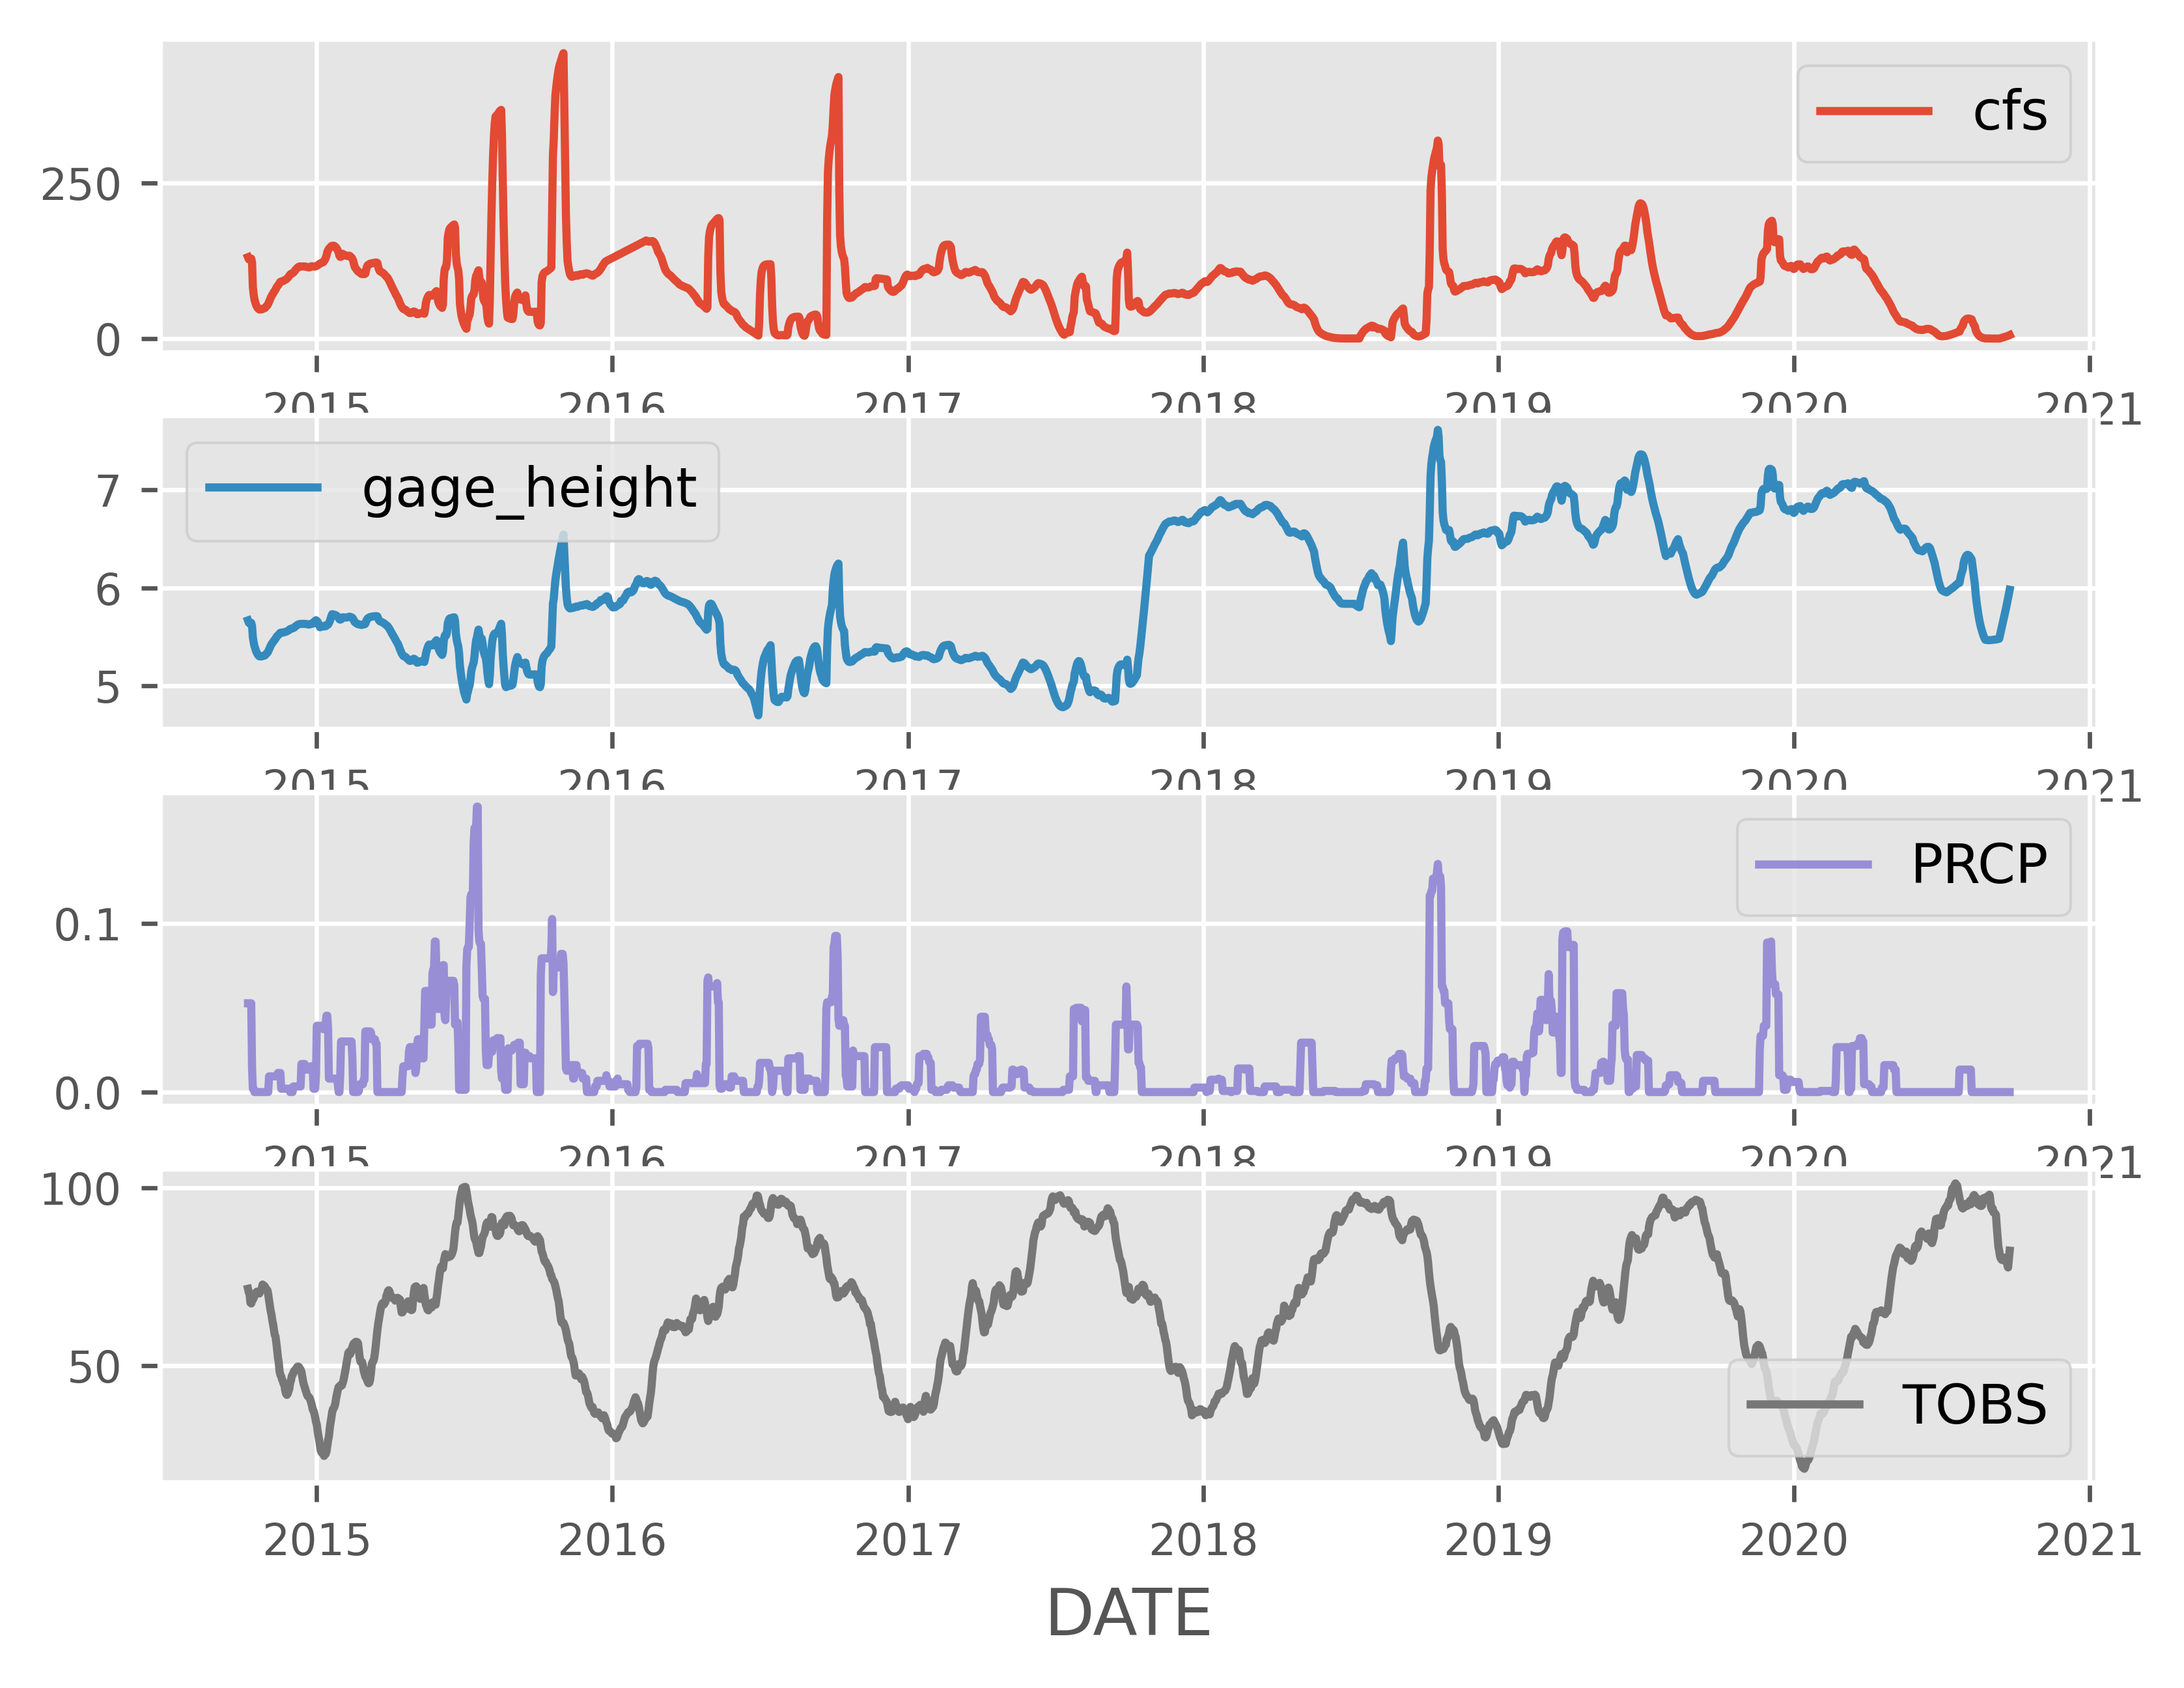

In [79]:
fig,ax = plt.subplots(dpi=600)
(dd_monoindex
 .groupby(pd.Grouper(key='datetime',  freq='D'))
 .median(numeric_only=True)
 .merge(temp_df,left_index=True,right_on='DATE', how='inner', validate='1:1')
 .set_index('DATE')
 .loc['2014':,['cfs','gage_height','PRCP','TOBS']]
 .interpolate()
 .rolling(15)
 .mean()
 .plot(subplots=True, figsize=(10,8),ax=ax, fontsize=8)
);

In [80]:
dd2 = (dd_monoindex
 .groupby(pd.Grouper(key='datetime',  freq='D'))
 .median(numeric_only=True)
 .merge(temp_df,left_index=True,right_on='DATE', how='inner', validate='1:1')
 .query('cfs < 400')
 .assign(DATE = lambda df: pd.to_datetime(df.DATE))
)

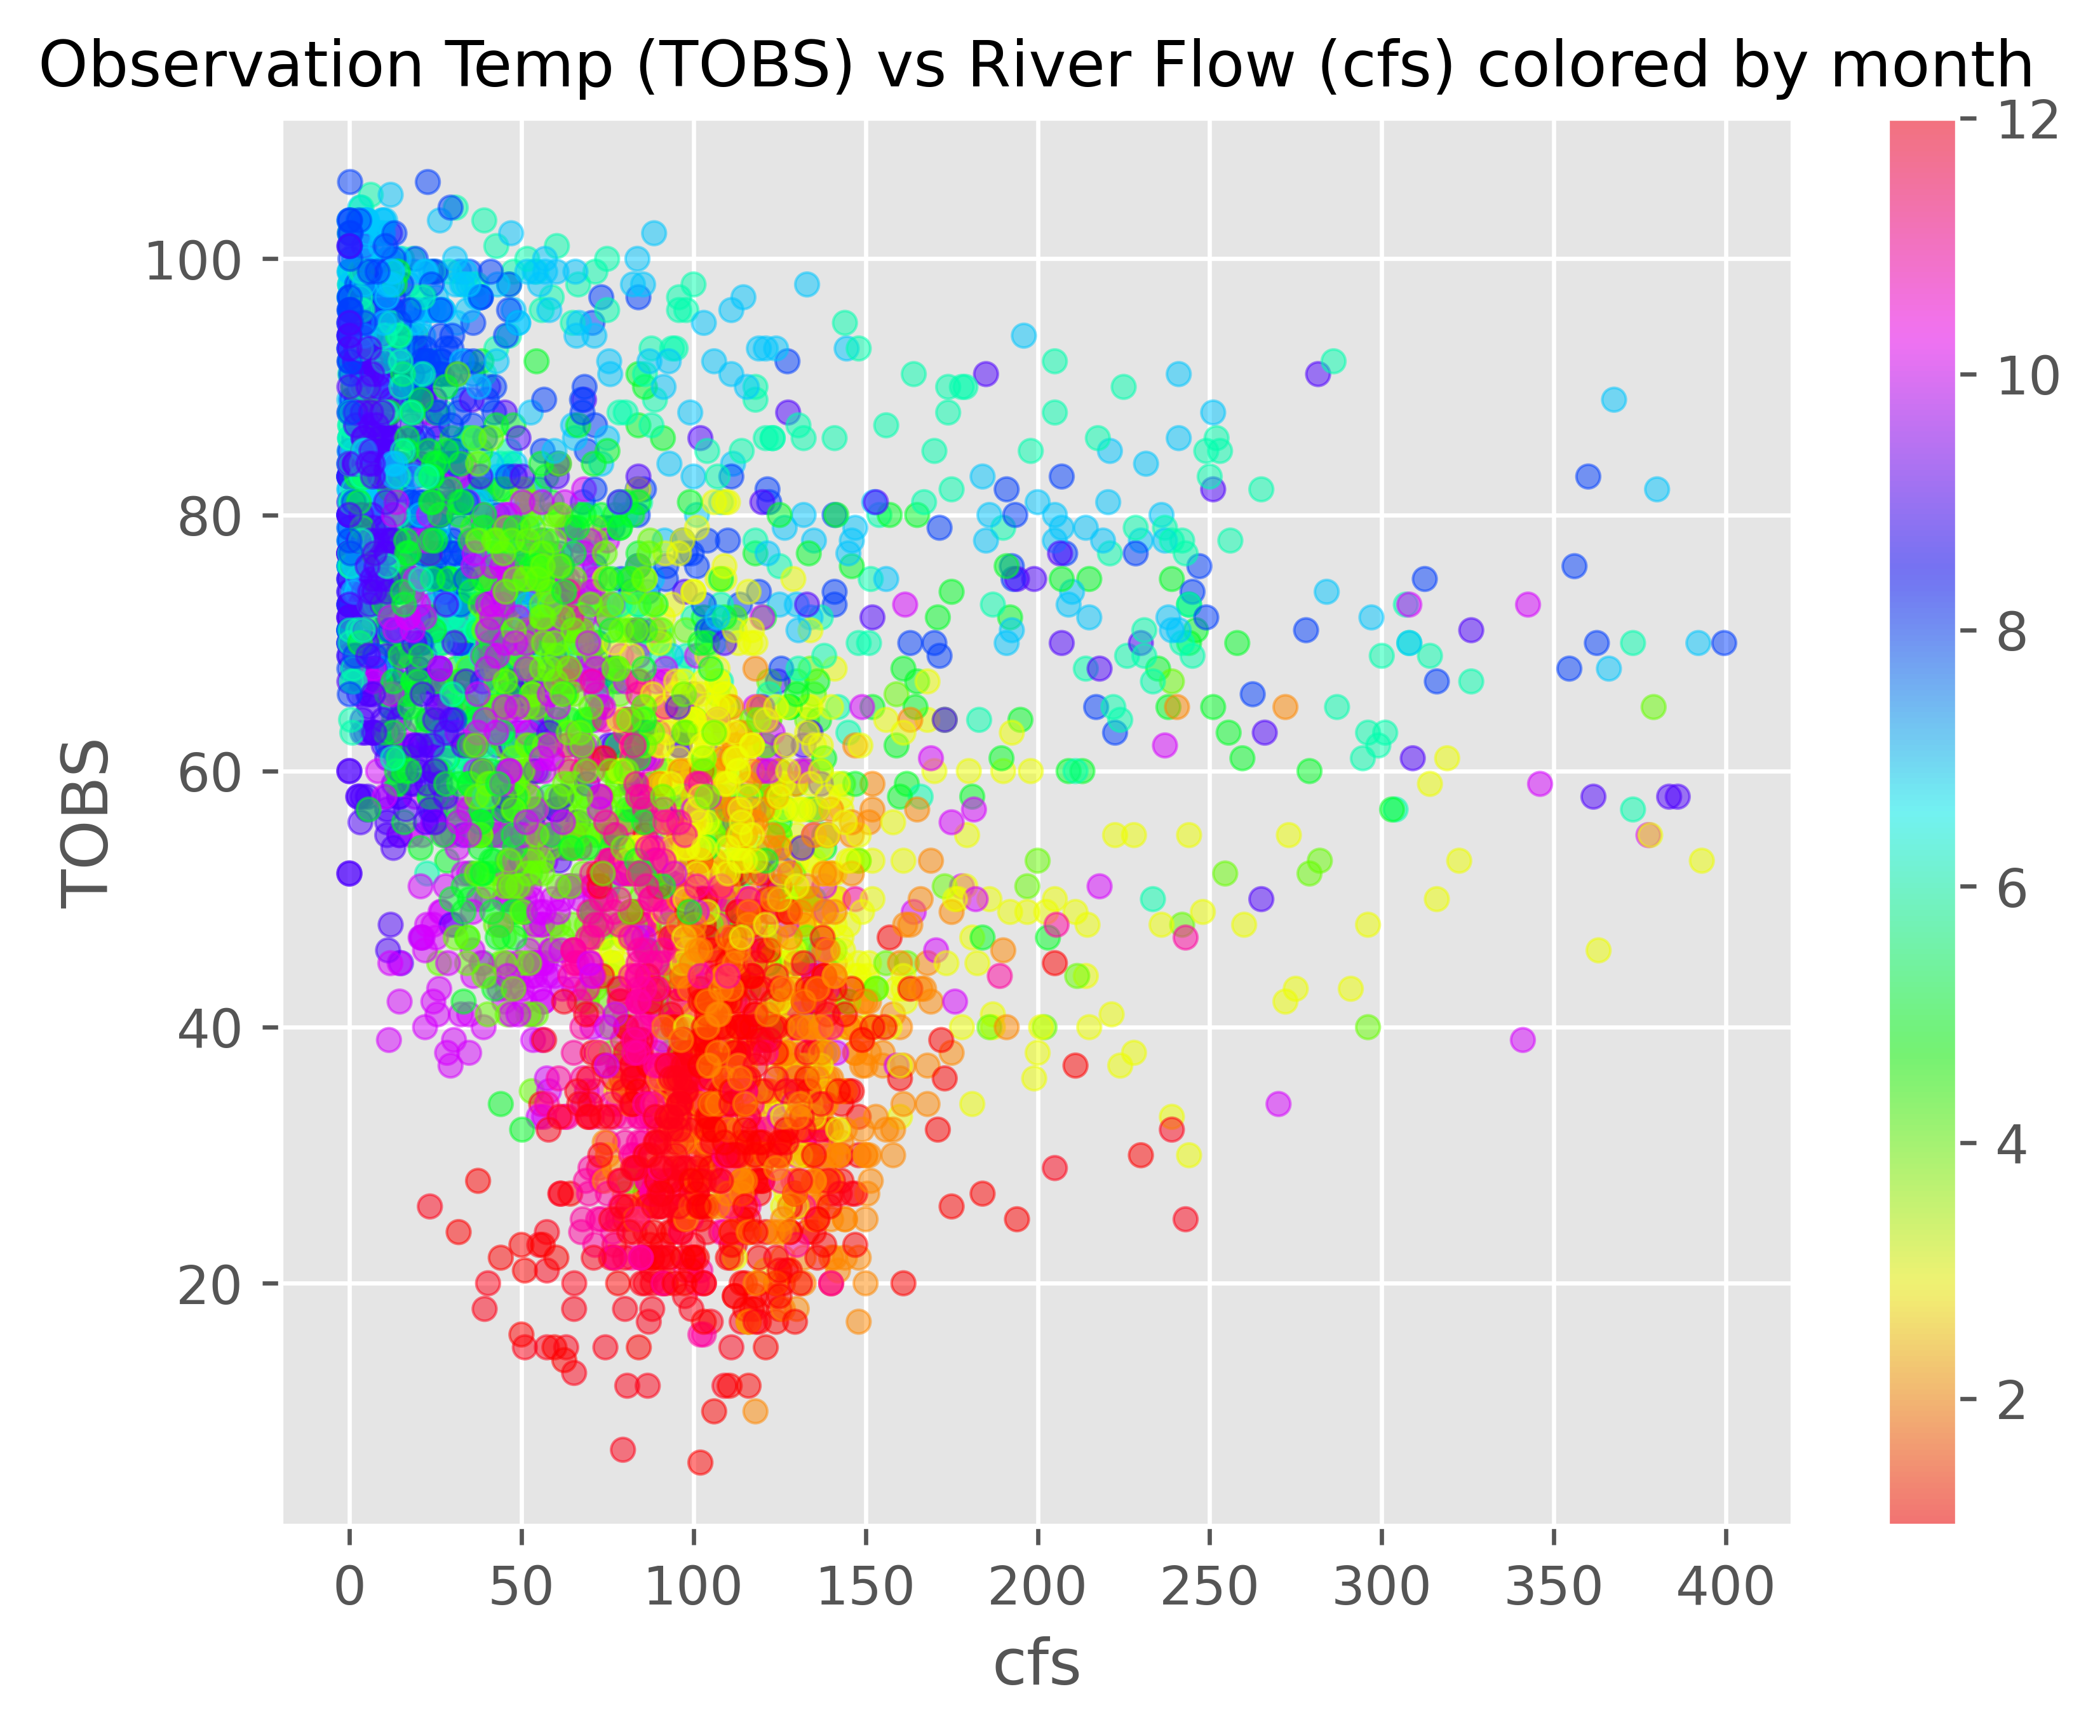

In [81]:
fig,ax = plt.subplots(dpi=600)

(dd2
 .plot.scatter(x='cfs', y='TOBS', c=dd2.DATE.dt.month, ax=ax, colormap='hsv', alpha=0.5)
)
ax.set_title('Observation Temp (TOBS) vs River Flow (cfs) colored by month', fontsize=12)
plt.show()

### Pset
1. Create dataframes from the provided data in the book
2. What type of join is required to get the location of each employee based on the dataframe structure?
3. How could the join be validated?

In [82]:
empl_comp = pd.DataFrame({'name':['Fred','John','Sally','Annie'], 'company':['AMZN','GOOG','GOOG','NFLX']})

comp_loc = pd.DataFrame({'ticker':['AMZN','GOOG'], 'name':['Seattle','SanFrancisco']})

In [83]:
(empl_comp
 .merge(comp_loc, left_on='company', right_on='ticker', how='left', validate='m:1', suffixes=('_employee','_location'))
)

name_employee company ticker name_location
0          Fred    AMZN   AMZN       Seattle
1          John    GOOG   GOOG  SanFrancisco
2         Sally    GOOG   GOOG  SanFrancisco
3         Annie    NFLX    NaN           NaN

## Ch 33 Exporting Data
While most of the information in the book is targeted at exploring, cleaning and visualizing data, this section deals with exporting the data back out of the system to share with others.  There are a number of mechanisms and types of exports available within pandas, and this section will provide and overview of the options.

The examples here will continue to use the dirty devil river dataset to support the demonstrations.

### Reading and Writing data
There are a number of ingest and export options within pandas.  The read functions all begin with read_, while the export side all begin with to_.  Each of the most common methods will be reviewed as part of this section.

### Export to CSV
The most common and the most frequently seen file storage option, comma seperated values (CSV), offers a human readable format which is acceptable to just about every system that ingests data.  The positive attributes end there, because the CSV format will not store any information about types nor has there been enough consistancy in CSV formatting (headers, indexes, etc) to allieviate some of the short falls.  This is why the pandas read_csv() function has over 40 parameters.  

To write to a csv simply call to_csv against a dataframe.  Some interesting behaviors to note.  
- By default, the index is kept as a field, but if  you read it back in a new index will be added
- There are many different parameters to help with improving CSV eport and import, but most people ignore them.

In [84]:
print(dd.head().to_csv()) # using print to avoid creating files

datetime,agency_cd,site_no,tz_cd,cfs,144166_00060_cd,gage_height,144167_00065_cd
2001-05-07 01:00:00-06:00,USGS,9333500,MDT,71.0,A:[91],,
2001-05-07 01:15:00-06:00,USGS,9333500,MDT,71.0,A:[91],,
2001-05-07 01:30:00-06:00,USGS,9333500,MDT,71.0,A:[91],,
2001-05-07 01:45:00-06:00,USGS,9333500,MDT,70.0,A:[91],,
2001-05-07 02:00:00-06:00,USGS,9333500,MDT,70.0,A:[91],,



In [85]:
dd.head().to_csv('dd_csv.csv')
dd_csv = pd.read_csv('dd_csv.csv')

In [86]:
dd_csv # Note the index behavior

datetime agency_cd  site_no tz_cd   cfs 144166_00060_cd  \
0  2001-05-07 01:00:00-06:00      USGS  9333500   MDT  71.0          A:[91]   
1  2001-05-07 01:15:00-06:00      USGS  9333500   MDT  71.0          A:[91]   
2  2001-05-07 01:30:00-06:00      USGS  9333500   MDT  71.0          A:[91]   
3  2001-05-07 01:45:00-06:00      USGS  9333500   MDT  70.0          A:[91]   
4  2001-05-07 02:00:00-06:00      USGS  9333500   MDT  70.0          A:[91]   

   gage_height  144167_00065_cd  
0          NaN              NaN  
1          NaN              NaN  
2          NaN              NaN  
3          NaN              NaN  
4          NaN              NaN

### Excel Exports
Just as with the CSV option, the next landing spot for data export is excel.  This program is so familiar to business it is difficult to avoid.  That said, you will need the openpyxl engine available to interact with the data.  There are other quirks as well.  The Excel exxport option does not like timezones, so they would need to be stripped before conducting the export.  On the plus side, the sheet parameter can be leveraged to structure the excel output.

In [87]:
(dd
 .head()
 .reset_index()
 .assign(datetime = lambda df: df.datetime.dt.tz_convert(tz=None))
 .set_index('datetime')
 .to_excel('dd_excel.xlsx'))

### Feather
Feather is a binary file format.  It has the advantage of maintaining type information for the data.  It is also optimized for columnar data which is aligned with DataFrame structures.  It should be noted that the use of this format requires the feather-format libarary.  It is a fast and language friendly model if you are dealing with other language types (R in particular).  A detailed example will not be provided, but it is something to consider if sharing large amounts of data and read write is a constraint.

### SQL
The most prevalent data storage is relational tables in an SQL system.  Pandas has the option to directly store data into an SQL table.  Python comes with SQLite, which is a widely leveraged SQL system that allows for optimized data storage for a given solution. It requires loading SQLite and a database Operational library (SQLalchemy in this case).

In [88]:
import sqlite3

In [89]:
con = sqlite3.connect('dd.db')

In [90]:
dd.to_sql('dd', con, if_exists='replace')

539305

> Lets Read from the created database

In [91]:
import sqlalchemy as sa

In [92]:
eng = sa.create_engine('sqlite:///dd.db')

In [93]:
sa_con = eng.connect()

In [94]:
dd2 = pd.read_sql('dd',sa_con, index_col='datetime')

In [95]:
dd2.equals(dd)

False

In [96]:
dd2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 539305 entries, 2001-05-07 01:00:00-06:00 to 2020-09-28 09:30:00-06:00
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   agency_cd        539305 non-null  object 
 1   site_no          539305 non-null  int64  
 2   tz_cd            539305 non-null  object 
 3   cfs              493124 non-null  float64
 4   144166_00060_cd  493124 non-null  object 
 5   gage_height      433377 non-null  float64
 6   144167_00065_cd  433377 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 32.9+ MB


In [97]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 539305 entries, 2001-05-07 01:00:00-06:00 to 2020-09-28 09:30:00-06:00
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   agency_cd        539305 non-null  object 
 1   site_no          539305 non-null  int64  
 2   tz_cd            539305 non-null  object 
 3   cfs              493124 non-null  float64
 4   144166_00060_cd  493124 non-null  object 
 5   gage_height      433377 non-null  float64
 6   144167_00065_cd  433377 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 32.9+ MB


### A different route
I have accessed the SQLite database created above in the dd.to_sql() statement through the SQLite interface.  Showing one row only, it is clear that the original timezone information was dropped from the index.  This is why the dd2.equals(dd) is false in the cell above.
> **NOTE**: The command prompt access to sqlite was not working, so using jupyter to access.

The created dd2 database must have the timezone information added back to the index to create equivalency.

In [98]:
c = con.cursor()

In [99]:
c.execute("SELECT * FROM dd")
print(c.fetchone()) # No timezone data
dd.head(1)

('2001-05-07 01:00:00-06:00', 'USGS', 9333500, 'MDT', 71.0, 'A:[91]', None, None)


agency_cd  site_no tz_cd   cfs 144166_00060_cd  \
datetime                                                                   
2001-05-07 01:00:00-06:00      USGS  9333500   MDT  71.0          A:[91]   

                           gage_height 144167_00065_cd  
datetime                                                
2001-05-07 01:00:00-06:00          NaN             NaN

In [101]:
(dd2
 .reset_index()
 .assign(datetime = lambda df: df.datetime.dt.tz_convert('America/Denver'))
 .set_index('datetime')
 .round(3)
).equals(dd)

False

#### UNCLEAR ISSUE
The Indexes seem to match when recreating the code, and the Datatime was not lost in the conversion.  When converting the data, the two frames, dd and dd2, are still not equivalent.  Unfortunately, the is not worth continuing to pursue.  In instances when datatime data is being stored, unless it is truly critical datetime information will be dropped for relative timestamps.  

### JSON
Serializing data from web applications is a very common practice, and the most common storage format is JSON.  JavaScript Object Notation is a very flexible format for data storage, and represents a dictionary type system with keys and values nested at various levels depending on the data structure.  Pandas has both a to_dict() and a to_json() option for both datastructures.  The round trip process is shown below for both.

In [102]:
obj = dd.to_dict()

In [103]:
# there is no read_dict() option in pandas, so instead there is a class method within the dataframe class from_dict()
dd2 = pd.DataFrame.from_dict(obj)

In [104]:
dd2.equals(dd)

True

In [105]:
dd.to_json('dd.json.gz')

In [106]:
dd2 = pd.read_json('dd.json.gz')

In [107]:
dd2.head(2)

agency_cd  site_no tz_cd   cfs 144166_00060_cd  \
2001-05-07 07:00:00      USGS  9333500   MDT  71.0          A:[91]   
2001-05-07 07:15:00      USGS  9333500   MDT  71.0          A:[91]   

                     gage_height 144167_00065_cd  
2001-05-07 07:00:00          NaN            None  
2001-05-07 07:15:00          NaN            None

In [108]:
dd2.equals(dd) # timezone problems again

False

In [109]:
(dd2
 .reset_index()
 .rename(columns={'index':'datetime'})
 .assign(datetime = lambda df: df.datetime.dt.tz_localize('UTC').dt.tz_convert('America/Denver'))
 .set_index('datetime')
 .round(3)
).equals(dd)

True

### PSet
With dataset of your choice
1. export to csv
2. export to SQLite
3. export to Feather
4. export to JSON

In [110]:
(fifa.to_csv('fifa.csv'))

In [111]:
dd.to_sql('fifa', sqlite3.connect('fifa.db'), if_exists='replace')

539305

In [118]:
eng = sa.create_engine('sqlite:///fifa.db')
fifa2 = pd.read_sql('fifa',eng.connect())
fifa2.round(3).equals(fifa)

False

In [119]:
fifa.to_json('fifa.json.gz')

In [120]:
fifa2 = pd.read_json('fifa.json.gz')

In [135]:
(fifa2
 .assign(shoot_out = lambda df: df.shoot_out.astype('boolean'))
).equals(fifa)

False

In [136]:
fifa.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Columns: 25 entries, date to away_team_mean_midfield_score
dtypes: bool(1), category(8), datetime64[ns](1), float64(8), int32(4), int8(2), object(1)
memory usage: 2.6+ MB


In [137]:
fifa2.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 23921 entries, 0 to 23920
Columns: 25 entries, date to away_team_mean_midfield_score
dtypes: bool(2), datetime64[ns](1), float64(8), int64(6), object(8)
memory usage: 4.4+ MB


#### JSON impact
Most of the category designation were lost in the JSON storage. When importing the data back into pandas for evaluation, this would require the data to be converted back to the format it was originally tweaked to leverage memory and datatype optimizations.  All eight categories were lost, one boolean was created, and the interger formats were all converted to int64.